The goal of this Notebook is to take the parts of NovemberPhyloProc.ipynb that I expect to go into the actual manuscript.

# Figure Outline

* Figure 1. Antibodies over time.

* Figure 2. Weighted unifrac PCoA

* Table 1. Kernel regression and weighted unifrac 1 test - binomial

* Table S1. Kernel regression and weighted unifrac 1 test - gaussian

* Table S2. Weighted unifrac components 2-N

* Figure S1. Jensen Shannon at different agglomeration levels.

* Figure S2. Statistically significant (p< 0.05, q < 0.2) family genus and species abundances (clr transformed) regressed against weighted unifrac 1.

* Table S3. All family - genus and species vs antibody vs glm scores.

* Figure 3. Stacked bars of key groups ordered by weighted unifrac axis 1.

* Figure S3. Groups associated with IgGs.

* Figure 4. Proportionality heat-map

* Other supplements: The entire data table
    * Basically the components of psN2, except the tree?
    * Or can I just release the input data files?

3/20/2017
Re-ran whole pipeline end-to-end. Hits on everything (including igg gp41 0 day) except only trending on gp41 Month 6.5. However I don't see family level groups for gp41 that relate to community structure (q < 0.2, p < 0.05). I may just try running everything end to end a few more times to see what happens. This because I want to see how consistant (or otherwise) the results are between runs.
Also, I'm going to start setting seeds now.

# Loading libraries, functions and data

## Libraries

In [1]:
# only use library paths in the anaconda environment

#.libPaths(grep('anaconda3', .libPaths(), value = T))

In [2]:
.libPaths()

[1] "/home/jcram/R/x86_64-pc-linux-gnu-library/3.4"                
[2] "/home/jcram/Programs/anaconda3/envs/nyvac-lab-2/lib/R/library"

In [3]:
R.version

               _                           
platform       x86_64-pc-linux-gnu         
arch           x86_64                      
os             linux-gnu                   
system         x86_64, linux-gnu           
status                                     
major          3                           
minor          4.1                         
year           2017                        
month          06                          
day            30                          
svn rev        72865                       
language       R                           
version.string R version 3.4.1 (2017-06-30)
nickname       Single Candle               

In [4]:
# https://stackoverflow.com/questions/46354826/have-a-function-that-calls-library-and-takes-either-a-package-or-its-name-as-inp


# Also return package version when loading in packages
# accept strings or functions
libver <- function(pac){

    pac <- as.character(substitute(pac))
    library(pac, character.only=TRUE)
    packageVersion(pac)
    }

In [5]:
#libver("dada2")
#libver("ggplot2")

In [6]:
# Much of the data handling
libver('phyloseq')

Warning message:
“package ‘phyloseq’ was built under R version 3.4.3”

[1] ‘1.22.3’

In [7]:
# A bunch of environments, including ggplot, dplyr, tidyr, and broom, which I use a lot
libver('tidyverse')

── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 2.2.1     ✔ purrr   0.2.4
✔ tibble  1.4.2     ✔ dplyr   0.7.4
✔ tidyr   0.8.0     ✔ stringr 1.3.0
✔ readr   1.1.1     ✔ forcats 0.3.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


[1] ‘1.2.1’

In [8]:
# Mostly for concatenating ggplots
library(gridExtra); packageVersion("gridExtra")


Attaching package: ‘gridExtra’

The following object is masked from ‘package:dplyr’:

    combine



[1] ‘2.2.1’

In [9]:
# I use this surprisingly not a lot here.
library(vegan); packageVersion("vegan")

Warning message:
“package ‘vegan’ was built under R version 3.4.3”Loading required package: permute
Warning message:
“package ‘permute’ was built under R version 3.4.3”Loading required package: lattice
This is vegan 2.4-6


[1] ‘2.4.6’

In [10]:
# For making trees
# libver('phangorn')

In [11]:
# A prerequesite to phangorn
# libver("DECIPHER")

In [12]:
# Some pre-processing stuff
# libver("dada2")

In [13]:
# I usually reshape with tidyverse tools now, but melt and cast are often easier in a pinch
# libver("reshape2")

In [14]:
# For replacing NaNs without too much thought.
libver("imputeMissings")


Attaching package: ‘imputeMissings’

The following object is masked from ‘package:dplyr’:

    compute



[1] ‘0.0.3’

In [15]:
# Deal with proportional data, especially useful for calculating proportionality phi
libver('compositions')

Loading required package: tensorA

Attaching package: ‘tensorA’

The following object is masked from ‘package:base’:

    norm

Loading required package: robustbase
Loading required package: energy
Loading required package: bayesm
Welcome to compositions, a package for compositional data analysis.
Find an intro with "? compositions"


Attaching package: ‘compositions’

The following objects are masked from ‘package:stats’:

    cor, cov, dist, var

The following objects are masked from ‘package:base’:

    %*%, scale, scale.default



[1] ‘1.40.1’

In [16]:
# Works with tidyverse to make model output tidy
libver('broom')

[1] ‘0.4.4’

In [17]:
# Make pretty tables
libver('knitr')
libver('kableExtra')

[1] ‘1.20’

Warning message:
“package ‘kableExtra’ was built under R version 3.4.3”

[1] ‘0.8.0’

In [18]:
# Let those pretty tables actually show up in a jupyter notebook
library('IRdisplay')

In [19]:
# For bootstrapping
libver('boot')


Attaching package: ‘boot’

The following object is masked from ‘package:robustbase’:

    salinity

The following object is masked from ‘package:lattice’:

    melanoma



[1] ‘1.3.20’

In [20]:
# Calculate kernel regressions
libver("MiRKAT")

Loading required package: survival

Attaching package: ‘survival’

The following object is masked from ‘package:boot’:

    aml

The following object is masked from ‘package:robustbase’:

    heart

Loading required package: PearsonDS
Loading required package: GUniFrac
Loading required package: ape
Warning message:
“package ‘ape’ was built under R version 3.4.3”
Attaching package: ‘ape’

The following object is masked from ‘package:compositions’:

    balance

Loading required package: matrixStats
Warning message:
“package ‘matrixStats’ was built under R version 3.4.3”
Attaching package: ‘matrixStats’

The following objects are masked from ‘package:robustbase’:

    colMedians, rowMedians

The following object is masked from ‘package:dplyr’:

    count

Loading required package: MASS

Attaching package: ‘MASS’

The following object is masked from ‘package:dplyr’:

    select



[1] ‘1.0’

In [21]:
#
libver("car")


Attaching package: ‘car’

The following object is masked from ‘package:boot’:

    logit

The following object is masked from ‘package:dplyr’:

    recode

The following object is masked from ‘package:purrr’:

    some



[1] ‘2.1.4’

In [22]:
#libver(mclust)

In [23]:
#libver(chemometrics)

In [24]:
libver(purrrlyr)

[1] ‘0.0.2’

In [25]:
libver('qvalue')

[1] ‘2.8.0’

## Functions

I have put the functions in a library file

In [26]:
source('libraries/library096.R')

## Data

In [27]:
# Set upOriginal to false, if you want to used user-reprocessed data.
# Results may differ slightly from those in the manuscript due to inter-run variation
# especially in the tree-ing algorithm.
 upOriginal <- TRUE
# upOriginal <- FALSE

In [28]:
# For permutation tests, how fast do things need to run
# 9999 for most runs, 99999 for publication quality ones suggested
jnperm <- 99999

In [29]:
# Data paths
getwd()
(mapping_file_path <- file.path('data', 'mapping_file_096a.csv'))
(immune_file_path <- file.path('data', 'immune096b.csv'))

if(upOriginal){
     seqtab_file_path <- file.path('data', 'seqtab.nochimNov2017.csv')
     taxa_file_path <- file.path('data', 'TaxaNov2017.csv')
     tree_path <- file.path('data', 'phylogeny096NovTree.tre')
    } else {
     seqtab_file_path <- file.path('data1', 'seqtab.nochimMar2018.csv')
     taxa_file_path <- file.path('data1', 'TaxaMar2018.csv')
     tree_path <- file.path('data1', 'phylogeny096Mar2018tre.tre')
}

seqtab_file_path
taxa_file_path
tree_path

[1] "/home/jcram/Projects/Nyvac096Microbiome"

[1] "data/mapping_file_096a.csv"

[1] "data/immune096b.csv"

[1] "data/seqtab.nochimNov2017.csv"

[1] "data/TaxaNov2017.csv"

[1] "data/phylogeny096NovTree.tre"

In [30]:
# Sequence data
seqtab.nochim.data <- read.csv(seqtab_file_path)

seqtabNames = gsub('\\.', '-',
    gsub('.fastq', '', seqtab.nochim.data$X)
                   )

seqtab.nochim = as.matrix(seqtab.nochim.data[,-1])
rownames(seqtab.nochim) = seqtabNames

In [31]:
# Taxa names
taxa.data <- read.csv(taxa_file_path)
taxa = taxa.data[,-1]

## I reverse complemented the sequences to generate the taxonomy
# (but only in this latest re-run, not the original)
## The following undoes that reverse complement to get original sequence
#rownames(taxa) = dada2:::rc(taxa.data[,1]) 

if(upOriginal){
    rownames(taxa) = (taxa.data[,1])} else {
    rownames(taxa) = dada2:::rc(taxa.data[,1]) 
}

taxa <- as.matrix(taxa)

In [32]:
# Mapping file
mapping.data <- read_csv(mapping_file_path) %>%
mutate(pub_id = sapply(pub_id,  function(x) {as.numeric(gsub("096-", "", x))}))
#mapping = mapping.data[,-1]
#rownames(mapping) = mapping.data[,1]
#mapping <- as.matrix(mapping)

Parsed with column specification:
cols(
  SampleID = col_character(),
  BarcodeSequence = col_character(),
  LinkerPrimerSequence = col_character(),
  ReversePrimer = col_character(),
  run_prefix = col_character(),
  pub_id = col_character(),
  Sex = col_character(),
  Visit = col_integer(),
  visitRank = col_integer(),
  RXCode = col_character(),
  Description = col_character()
)


In [33]:
head(mapping.data)

SampleID,BarcodeSequence,LinkerPrimerSequence,ReversePrimer,run_prefix,pub_id,Sex,Visit,visitRank,RXCode,Description
Sample-57,TTACGC,GCGGACTACCVGGGTATCTAAT,"GCACTCCTRCGGGAGGCAGCAG,GCACACCTACGGGTGGCTGC,GCACACCTACGGGTGGCAGC",JH3VWZ201,282,Male,9,1,T1,"NYVAC (2) & placebo mo(0,1) + NYVAC (2) & AIDSVAX B/E mo(3,6)"
Sample-58,TTAGGT,GCGGACTACCVGGGTATCTAAT,"GCACTCCTRCGGGAGGCAGCAG,GCACACCTACGGGTGGCTGC,GCACACCTACGGGTGGCAGC",JH3VWZ201,282,Male,12,2,T1,"NYVAC (2) & placebo mo(0,1) + NYVAC (2) & AIDSVAX B/E mo(3,6)"
Sample-60,TTCCAC,GCGGACTACCVGGGTATCTAAT,"GCACTCCTRCGGGAGGCAGCAG,GCACACCTACGGGTGGCTGC,GCACACCTACGGGTGGCAGC",JH3VWZ201,176,Female,9,1,T1,"NYVAC (2) & placebo mo(0,1) + NYVAC (2) & AIDSVAX B/E mo(3,6)"
Sample-61,TTGTAC,GCGGACTACCVGGGTATCTAAT,"GCACTCCTRCGGGAGGCAGCAG,GCACACCTACGGGTGGCTGC,GCACACCTACGGGTGGCAGC",JH3VWZ201,176,Female,12,2,T1,"NYVAC (2) & placebo mo(0,1) + NYVAC (2) & AIDSVAX B/E mo(3,6)"
Sample-62,TTGTGT,GCGGACTACCVGGGTATCTAAT,"GCACTCCTRCGGGAGGCAGCAG,GCACACCTACGGGTGGCTGC,GCACACCTACGGGTGGCAGC",JH3VWZ201,123,Female,12,1,T4,"DNA & placebo & AIDSVAX B/E mo(0,1) + NYVAC (2) & AIDSVAX B/E mo(3,6)"
Sample-63,TATCAC,GCGGACTACCVGGGTATCTAAT,"GCACTCCTRCGGGAGGCAGCAG,GCACACCTACGGGTGGCTGC,GCACACCTACGGGTGGCAGC",JH3VWZ201,49,Female,9,1,T2,"NYVAC (2) & AIDSVAX B/E mo(0,1,3,6)"


In [34]:
# Immune Data
immune.data0 <- read_csv(immune_file_path)
immune.data <- mutate(immune.data0, pub_id = sapply(pub_id,  function(x) {as.numeric(gsub("096-", "", x))}))
levels(immune.data$antigen) <- gsub("[ /]", ".", levels(immune.data$antigen))

Parsed with column specification:
cols(
  visitno = col_integer(),
  rx_code = col_character(),
  type = col_character(),
  antigen = col_character(),
  mag = col_double(),
  mag_bl = col_double(),
  response = col_integer(),
  day = col_integer(),
  month = col_double(),
  ct = col_character(),
  response_j = col_double(),
  assay = col_character(),
  pub_id = col_character()
)


In [35]:
head(immune.data)

visitno,rx_code,type,antigen,mag,mag_bl,response,day,month,ct,response_j,assay,pub_id
5,CTRL,IgA,gp41,180.50,213.5,0,42,1.5,CTRL,-0.002373369,BAMA,41
7,CTRL,IgA,gp41,174.80,213.5,0,98,3.5,CTRL,-0.159842993,BAMA,41
9,CTRL,IgA,gp41,177.25,213.5,0,182,6.5,CTRL,0.173147267,BAMA,41
12,CTRL,IgA,gp41,173.00,213.5,0,364,12.0,CTRL,0.165522137,BAMA,41
5,CTRL,IgA,p24,447.20,454.3,0,42,1.5,CTRL,0.146694884,BAMA,41
7,CTRL,IgA,p24,766.80,454.3,0,98,3.5,CTRL,0.186938554,BAMA,41


In [36]:
# Phylogenetic tree
seqs <- dada2::getSequences(seqtab.nochim)
names(seqs) <- seqs

pt <- read.tree(file=tree_path)

pt2 <- phangorn::midpoint(pt)

In [37]:
immune.data$antigen %>% unique

[1] "gp41"               "p24"                "Con.6.gp120.B"     
[4] "ZM96.gp140"         "gp70_B.CaseA_V1_V2" "ANY.ENV.PTEG"

Save options to a variable

In [38]:
par0 <- options()

# Pre-processing

In [39]:
## minimal sample identification data
pub_id_key <- unique(immune.data[,c("pub_id", "rx_code", "ct")])

sample_sm0 <- dplyr::select(mapping.data, SampleID, pub_id, sex = Sex, muVisit = Visit, muVisitRank = visitRank)
sample_sm <- left_join(sample_sm0, pub_id_key, by = "pub_id") %>%
as.data.frame %>%
tibble::column_to_rownames(var = "SampleID")
# rownames(sample_sm)
# head(sample_sm)

Warning message:
“Column `pub_id` has different attributes on LHS and RHS of join”

In [40]:
# Make raw phyloseq object
ot <- otu_table(seqtab.nochim, taxa_are_rows=FALSE)

tt <- tax_table(taxa)
dimnames(tt) = dimnames(taxa)

spl <- sample_data(sample_sm)


psN is a really raw phyloseq object
* OTU names are given as accession numbers
* Numbers are in total counts
* We have samples from both time points

In [41]:
# Quite raw phyloseq object. Species names are given as accession numbers
psN <- phyloseq(ot, tt, spl, pt2)

psN

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 960 taxa and 47 samples ]
sample_data() Sample Data:       [ 47 samples by 6 sample variables ]
tax_table()   Taxonomy Table:    [ 960 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 960 tips and 959 internal nodes ]

I want to make a phyloseq object for use in essentally all of the subsequent analyses.
Features include:
* Some basic taxonomic pre-processing.
    * No uncharacterized phyla.
    * Only OTUs that show up at least 10% of the time in the final data set .
        * Do this after filtering samples.
* No tip-glomming. I'll save that untill later.
* Immune data is included in the sample data table. 
    * We'll do Andrew's representitive IgGs and IgAs.
* We only have samples from visit 1.
* We only have samples from experemental (not control) groups.

In [42]:
immune.data %>% pull(type) %>% unique

[1] "IgA"  "IgG"  "CD4+"

In [43]:
#immune.data %>% unite(type_antigen ,type, antigen, sep = "_")

In [44]:
immune.data %>% dplyr::select(pub_id, month, type, antigen, mag) %>% 
filter(month %in% c(0, 6.5, 12)) %>%
unite(type_antigen, type, antigen, sep = "_") %>%
unite(type_antigen_month,type_antigen, month, sep = "_Month_") %>%
spread(key = type_antigen_month, value = mag, drop = TRUE) -> immune.table

In [45]:
immune.table %>% head

pub_id,CD4+_ANY.ENV.PTEG_Month_0,CD4+_ANY.ENV.PTEG_Month_12,CD4+_ANY.ENV.PTEG_Month_6.5,IgA_gp41_Month_0,IgA_gp41_Month_12,IgA_gp41_Month_6.5,IgA_p24_Month_0,IgA_p24_Month_12,IgA_p24_Month_6.5,⋯,IgG_gp41_Month_6.5,IgG_gp70_B.CaseA_V1_V2_Month_0,IgG_gp70_B.CaseA_V1_V2_Month_12,IgG_gp70_B.CaseA_V1_V2_Month_6.5,IgG_p24_Month_0,IgG_p24_Month_12,IgG_p24_Month_6.5,IgG_ZM96.gp140_Month_0,IgG_ZM96.gp140_Month_12,IgG_ZM96.gp140_Month_6.5
3,0.025,NA,0.06780192,53.0,29.0,75.50,573.3,773.0,433.70,⋯,18352.75,1,1.00,7274.50,766.00,3020.00,30974.5,179.00,185.25,5384.00
4,0.025,NA,NA,18.5,NA,NA,404.5,NA,NA,⋯,NA,1,NA,NA,1499.00,NA,NA,1.00,NA,NA
5,0.025,0.025,0.02500000,157.0,239.7,206.00,377.0,1662.2,12705.50,⋯,169.50,1,1.00,1.00,375.00,1169.50,1776.0,7.25,1.00,377.50
7,0.025,0.025,0.02500000,4.0,71.0,125.25,2886.0,6346.5,4091.50,⋯,222.25,1,1.00,1.00,3730.25,2585.50,1874.5,1.00,1.00,43.00
12,0.025,0.025,0.05147362,22.0,175.5,271.00,446.5,2782.5,6338.75,⋯,23121.25,1,67.25,4326.25,3089.75,29983.25,32315.0,1.00,298.50,8202.75
14,0.025,0.025,0.30173181,18.0,73.2,163.75,183.0,2514.0,7305.50,⋯,31671.50,1,200.50,11818.25,95.50,30760.50,32343.5,32.75,719.25,7122.00


## Initial Taxonomic filter.
Some investegation suggested by the phyloseq tutorials
to identify phyla for removal, and to identify an abundance threshold

In [46]:
psN

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 960 taxa and 47 samples ]
sample_data() Sample Data:       [ 47 samples by 6 sample variables ]
tax_table()   Taxonomy Table:    [ 960 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 960 tips and 959 internal nodes ]

In [47]:
# skip the blanks
psN %>% subset_samples(!is.na(pub_id)) %>%
# OTUs must be characterized to phylum
subset_taxa(!is.na(Phylum)& !Phylum %in% c("", "uncharacterized")) -> psN_hasPhylum
psN_hasPhylum
# from 960 to 929 otus

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 929 taxa and 38 samples ]
sample_data() Sample Data:       [ 38 samples by 6 sample variables ]
tax_table()   Taxonomy Table:    [ 929 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 929 tips and 928 internal nodes ]

Identifying and removing phyla with very few taxa in them

In [48]:
prevdf = apply(X = otu_table(psN_hasPhylum),
                 MARGIN = ifelse(taxa_are_rows(psN_hasPhylum), yes = 1, no = 2),
                 FUN = function(x){sum(x > 0)})
# Add taxonomy and total read counts to this data.frame
prevdf = data.frame(Prevalence = prevdf,
                      TotalAbundance = taxa_sums(psN_hasPhylum),
                      tax_table(psN_hasPhylum))

plyr::ddply(prevdf, "Phylum", function(df1){cbind(mean(df1$Prevalence),sum(df1$Prevalence))})

Phylum,1,2
Actinobacteria,7.953846,517
Bacteroidetes,9.414634,1930
Elusimicrobia,2.000000,2
Firmicutes,9.711604,5691
Fusobacteria,5.875000,94
Proteobacteria,6.960000,348
Synergistetes,3.750000,15
Tenericutes,4.000000,4
Verrucomicrobia,6.000000,6


In [49]:
filterPhyla = c("Verrucomicrobia", "Tenericutes", "Elusimicrobia", "Synergistetes")
psN_MainPhyla = subset_taxa(psN_hasPhylum, !Phylum %in% filterPhyla)
psN_MainPhyla

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 922 taxa and 38 samples ]
sample_data() Sample Data:       [ 38 samples by 6 sample variables ]
tax_table()   Taxonomy Table:    [ 922 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 922 tips and 921 internal nodes ]

Warning message:
“Transformation introduced infinite values in continuous x-axis”

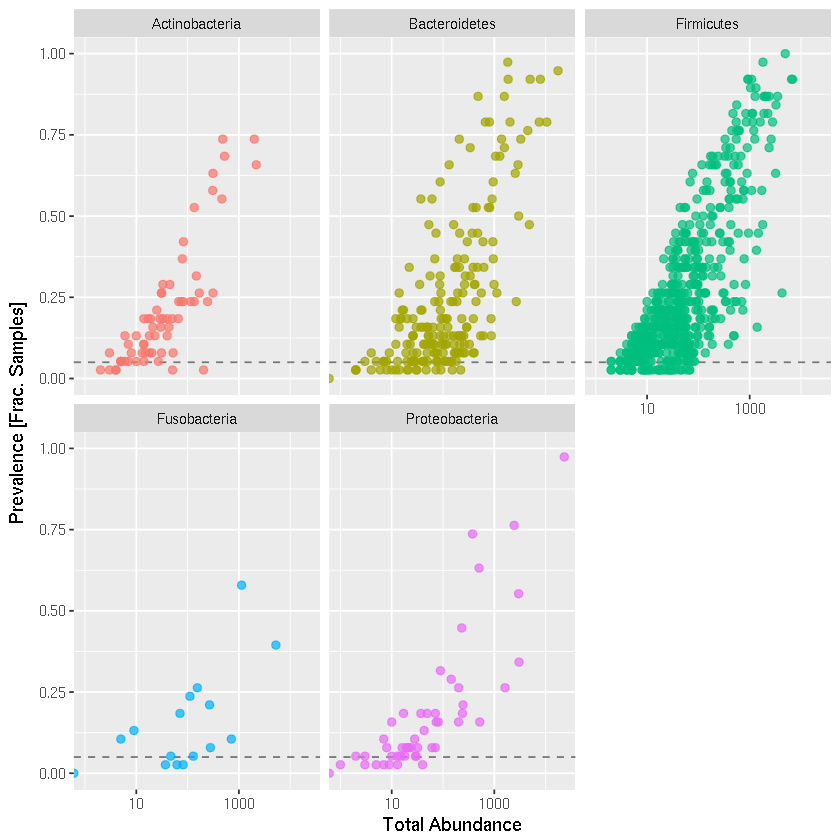

In [50]:
# Determining abundance threshold
prevdf1 = subset(prevdf, Phylum %in% get_taxa_unique(psN_MainPhyla, "Phylum"))
ggplot(prevdf1, aes(TotalAbundance, Prevalence / nsamples(psN_hasPhylum),color=Phylum)) +
  # Include a guess for parameter
  geom_hline(yintercept = 0.05, alpha = 0.5, linetype = 2) + geom_point(size = 2, alpha = 0.7) +
  scale_x_log10() +  xlab("Total Abundance") + ylab("Prevalence [Frac. Samples]") +
  facet_wrap(~Phylum) + theme(legend.position="none")

## Constructing psN2 
(phyloseq object of relative abundances)

And psN1 (phyloseq object of counts)

In [51]:
psN %>%
# add all the immune data
phylo_join(immune.table, by = "pub_id") %>%
# filter to just microbiome visit 1 and experemental treatments
subset_samples(muVisitRank == 1) %>%
subset_samples(ct == "T") %>%
# only otus from known taxa that show up frequently enough
subset_taxa(!is.na(Phylum)& !Phylum %in% c("", "uncharacterized")) %>%
subset_taxa(!Phylum %in% filterPhyla) %>%
# only otus that show up in at least 10% of samples
prevalence_filter_taxa %>%
# convert to relative abundance

tag_phyloseq%>%
# Instead of naming each taxon with its full sequence, we use the "tag" instead
swap.phyloseq.taxnames %>%
pass -> psN1 # Save pre relative abundance transformation

# add is-male
manColumn <- psN1 %>% sample_data %>% as('data.frame') %>% rownames_to_column  %>% mutate(isMale = testIsMaleVec(sex)) %>% dplyr::select(rowname, isMale)
psN1 <- phylo_join(psN1, manColumn, by = 'rowname')

## psN2 is like psN1 but with relative abundances
psN1 %>%
transform_sample_counts(function(x) {x/sum(x)}) %>%
# The "tag" is a new name that takes into account the rest of the taxonomy data
# the tag may need to be updated after any agglomeration
pass-> psN2



# Calculate weighted unifrac distances and role those in.
psN2.wuf <- phyloseq::distance(psN2, method = "wunifrac")
psN2.pcoa <- capscale(psN2.wuf ~ 1)
psN2.pcoa.df <- psN2.pcoa %>% scores(display = "sites") %>%
        as.data.frame %>% 
        rownames_to_column %>% 
        dplyr::select('rowname', 'MDS1', 'MDS2') %>%
        mutate(rMDS1 = rank(MDS1)) %>% # rank order of MDS1
        mutate(rrMDS1 = formatC(format = "d", rMDS1, flag = "0", width=ceiling(log10(max(rMDS1))))) %>%
        unite(newname, rrMDS1, rowname, sep = "_", remove = FALSE) %>%
        dplyr::select(-rrMDS1)

psN2 %>%
phylo_join(
    psN2.pcoa.df,
    by = 'rowname'
) -> psN2

## Even if the data are counts, 
## the weighted unifrac pcoa is still done on the relative abundances
psN1 %>%
phylo_join(
    psN2.pcoa.df,
    by = 'rowname'
) -> psN1

psN2
psN1

Warning message:
“Setting row names on a tibble is deprecated.”

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 536 taxa and 21 samples ]
sample_data() Sample Data:       [ 21 samples by 35 sample variables ]
tax_table()   Taxonomy Table:    [ 536 taxa by 10 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 536 tips and 535 internal nodes ]

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 536 taxa and 21 samples ]
sample_data() Sample Data:       [ 21 samples by 35 sample variables ]
tax_table()   Taxonomy Table:    [ 536 taxa by 10 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 536 tips and 535 internal nodes ]

How many participants that provided samples didn't have a day zero sample so we had to use something else?

In [52]:
psN2 %>% sample_data %>% data.frame %>% group_by(muVisit) %>% summarize(n = length(muVisit))

muVisit,n
2,3
9,11
12,7


# Immune figure
How to participants' immune profiles change over time?

In [53]:
# When were participants vaccinated?
# Copied from protocol apendix E
# visitno 1 is a screening visit, I assign it NaN
dayTable = data.frame(
    visitno = seq(from = 1, to = 14, by = 1),
    day = c(NaN, 0, 14, 28, 42, 84, 98, 168, 182, 196, 273, 364, 455, 545),
    month = c(NaN, 0, 0.5, 1, 1.5, 3, 3.5, 6, 6.5, 7, 9, 12, 15, 18)
)
vac <- data.frame(
    visitno = c(2, 4, 6, 8)
    )
vac <- left_join(vac, dayTable, by = 'visitno')

vac

visitno,day,month
2,0,0
4,28,1
6,84,3
8,168,6


In [54]:
# Representitive antigens for further considerations
# These are essentially zero (mag = 1) at baseline
ants1 <- c('Con.6.gp120.B', 'ZM96.gp140', 'gp70_B.CaseA_V1_V2')
# These have measurable baseline magnitudes
ants2 <- c('gp41', 'p24')

In [55]:
donor.immune <-  psN2 %>% sample_data %>% as('data.frame') %>% dplyr::select(pub_id) %>%
left_join(immune.data, by = 'pub_id')
donor.immune %>% head

Warning message:
“Column `pub_id` has different attributes on LHS and RHS of join”

pub_id,visitno,rx_code,type,antigen,mag,mag_bl,response,day,month,ct,response_j,assay
282,5,T1,IgA,gp41,352.00,109.5,0,42,1.5,T,-0.18339353,BAMA
282,7,T1,IgA,gp41,276.50,109.5,0,98,3.5,T,-0.10360764,BAMA
282,9,T1,IgA,gp41,333.25,109.5,0,182,6.5,T,0.19882813,BAMA
282,12,T1,IgA,gp41,1.00,109.5,0,364,12.0,T,0.15338760,BAMA
282,5,T1,IgA,p24,313.50,329.8,0,42,1.5,T,0.02648181,BAMA
282,7,T1,IgA,p24,377.50,329.8,0,98,3.5,T,-0.10988643,BAMA


In [56]:
psN %>% sample_data %>%
as('data.frame') %>% 
filter(!is.na(pub_id)) %>%
pull(pub_id) %>%
unique %>%
pass -> microbiomeCohort

In [57]:
immune.data %>% filter(pub_id %in% microbiomeCohort) %>%
pass -> donor.immune

donor.immune %>% head

visitno,rx_code,type,antigen,mag,mag_bl,response,day,month,ct,response_j,assay,pub_id
5,T1,IgA,gp41,352.00,109.5,0,42,1.5,T,-0.18339353,BAMA,282
7,T1,IgA,gp41,276.50,109.5,0,98,3.5,T,-0.10360764,BAMA,282
9,T1,IgA,gp41,333.25,109.5,0,182,6.5,T,0.19882813,BAMA,282
12,T1,IgA,gp41,1.00,109.5,0,364,12.0,T,0.15338760,BAMA,282
5,T1,IgA,p24,313.50,329.8,0,42,1.5,T,0.02648181,BAMA,282
7,T1,IgA,p24,377.50,329.8,0,98,3.5,T,-0.10988643,BAMA,282


Saving 6.67 x 6.67 in image


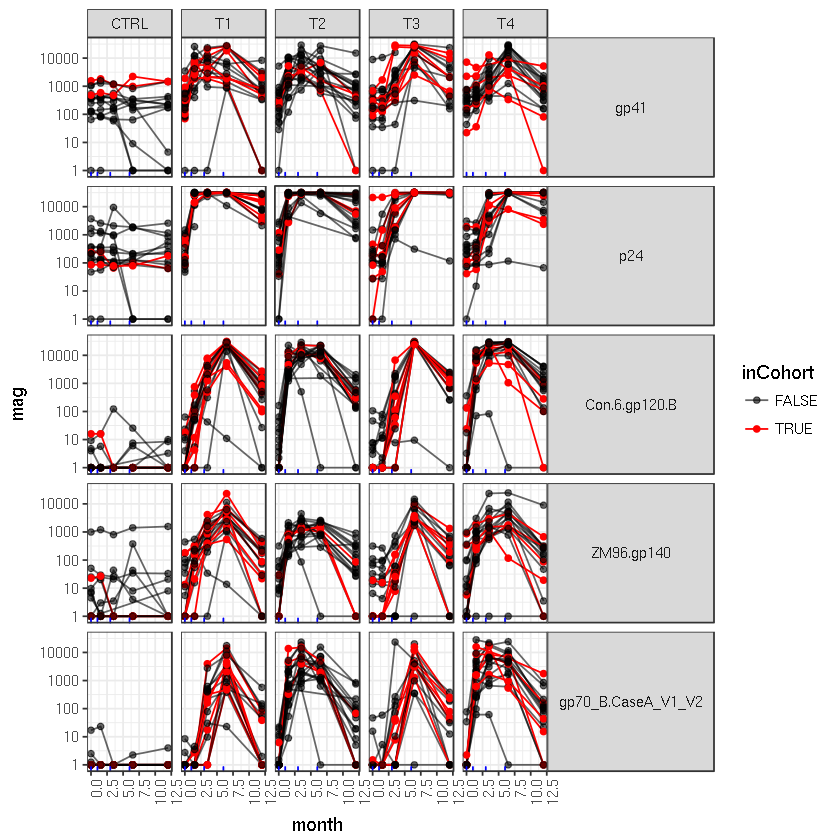

In [58]:
iggplot <- immune.data %>%
mutate(inCohort = pub_id %in% microbiomeCohort) %>%
filter(type == 'IgG', antigen %in% c(ants1, ants2)) %>%
mutate(antigen = factor(antigen, levels = c(ants2, ants1))) %>% # reorder facets
ggplot(aes(x = month, y =mag, group = pub_id, colour = inCohort, alpha = inCohort)) +
geom_line() +
geom_point() +
geom_rug(data = vac, aes(x = month), inherit.aes = F, color = 'blue') +
facet_grid(antigen ~ rx_code, labeller = label_wrap_gen()) +
theme_bw() +
theme(strip.text.y = element_text(angle = 0),
      axis.text.x = element_text(angle = 90, hjust = 1)) +
scale_y_log10(breaks = 10^(0:5)) +
scale_colour_manual(values = c("black", "red")) +
scale_alpha_manual(values = c(.6, 1))

iggplot

ggsave('figures/useiggsAllParticipants.png')
# To fix. Control groups don't show up in this version.

Saving 6.67 x 6.67 in image


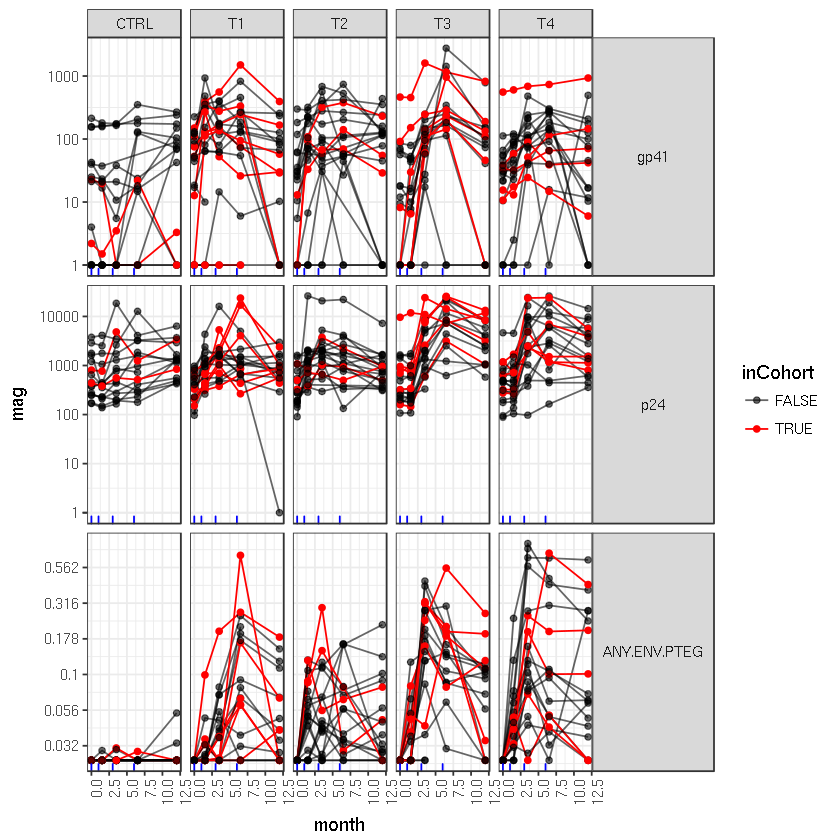

In [59]:
iggplot <- immune.data %>%
mutate(inCohort = pub_id %in% microbiomeCohort) %>%
filter(type %in% c('IgA', 'CD4+') & antigen %in% c(ants2, 'ANY.ENV.PTEG'))%>%
mutate(antigen = factor(antigen, levels = c(ants2, 'ANY.ENV.PTEG'))) %>% # reorder facets
ggplot(aes(x = month, y =mag, group = pub_id, colour = inCohort, alpha = inCohort)) +
geom_line() +
geom_point() +
geom_rug(data = vac, aes(x = month), inherit.aes = F, color = 'blue') +
facet_grid(antigen ~ rx_code, labeller = label_wrap_gen(), scales = 'free_y') +
theme_bw() +
theme(strip.text.y = element_text(angle = 0),
      axis.text.x = element_text(angle = 90, hjust = 1)) +
scale_y_log10(breaks = 10^c(
    seq(from = -2, to = 0, by = 0.25), seq(from = 0, to = 5, by = 1)
), labels = function(x) round(as.numeric(x), digits=3)) +
scale_colour_manual(values = c("black", "red")) +
scale_alpha_manual(values = c(.6, 1))

iggplot

ggsave('figures/useIgACD4AllParticipants.png')
# To fix. Control groups don't show up in this version.

Saving 6.67 x 6.67 in image


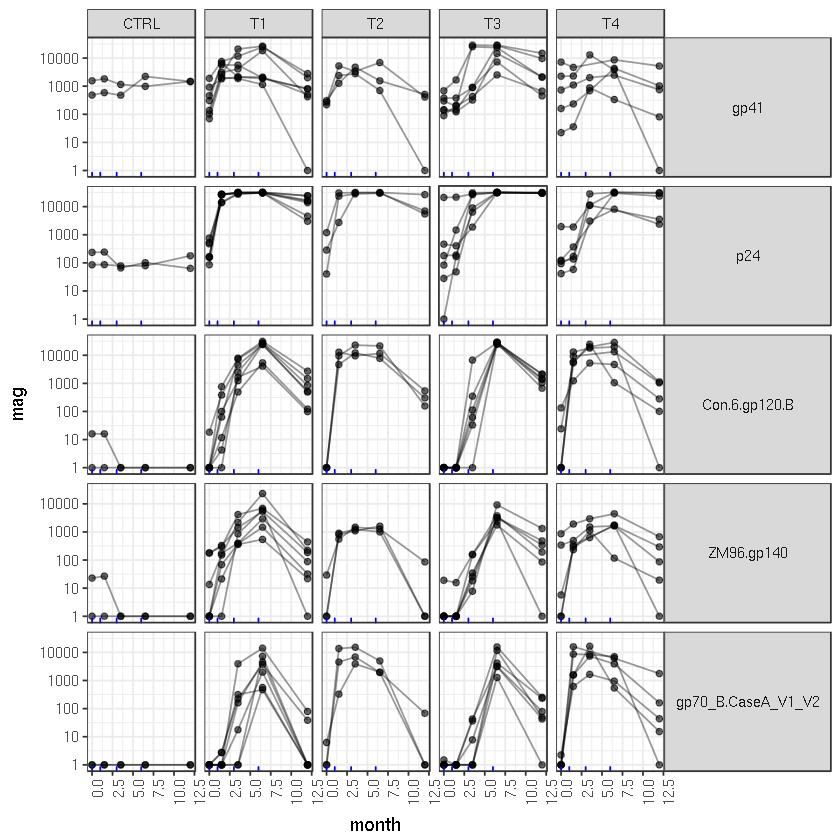

In [60]:
iggplot <- donor.immune %>% filter(type == 'IgG', antigen %in% c(ants1, ants2)) %>%
mutate(antigen = factor(antigen, levels = c(ants2, ants1))) %>% # reorder facets
ggplot(aes(x = month, y =mag, group = pub_id)) + geom_point(alpha = 0.6) + geom_line(alpha = 0.4) +
geom_rug(data = vac, aes(x = month), inherit.aes = F, color = 'blue') +
facet_grid(antigen ~ rx_code, labeller = label_wrap_gen()) +
theme_bw() + theme(strip.text.y = element_text(angle = 0), axis.text.x = element_text(angle = 90, hjust = 1)) +
scale_y_log10(breaks = 10^(0:5))
iggplot
ggsave('figures/useiggs.png')
# To fix. Control groups don't show up in this version.

## Number of participants per group

### All participants

In [61]:
immune.data %>% 
group_by(rx_code) %>%
summarize(Unique_ids = n_distinct(pub_id))

rx_code,Unique_ids
CTRL,16
T1,20
T2,20
T3,20
T4,20


### Participants with microbiome data

In [62]:
donor.immune %>% 
group_by(rx_code) %>%
summarize(Unique_ids = n_distinct(pub_id))

rx_code,Unique_ids
CTRL,2
T1,7
T2,3
T3,6
T4,5


# Weighted Unifrac analysis.

In [63]:
psN2.wuf <- phyloseq::distance(psN2, method = "wunifrac")

In [64]:
psN2.pcoa <- capscale(psN2.wuf ~ 1)

In [65]:
# How much variance si explained by each weighted unifrac axis
# Note, ten axes cover 95% of the variance. 
# I'm not going to look beyond that for any test.
data.frame(eig = psN2.pcoa$CA$eig) %>%
rownames_to_column('axis') %>%
mutate(proportion = eig/sum(eig)) %>%
mutate(cumulative = cumsum(proportion))

axis,eig,proportion,cumulative
MDS1,0.837317681,0.2911225525,0.2911226
MDS2,0.494340264,0.1718745497,0.4629971
MDS3,0.374098625,0.1300683707,0.5930655
MDS4,0.273563056,0.0951136911,0.6881792
MDS5,0.260966349,0.0907340086,0.7789132
MDS6,0.164756392,0.0572832779,0.8361965
MDS7,0.144299295,0.0501706580,0.8863671
MDS8,0.094422652,0.0328293119,0.9191964
MDS9,0.058944717,0.0204941766,0.9396906
MDS10,0.050652188,0.0176109911,0.9573016


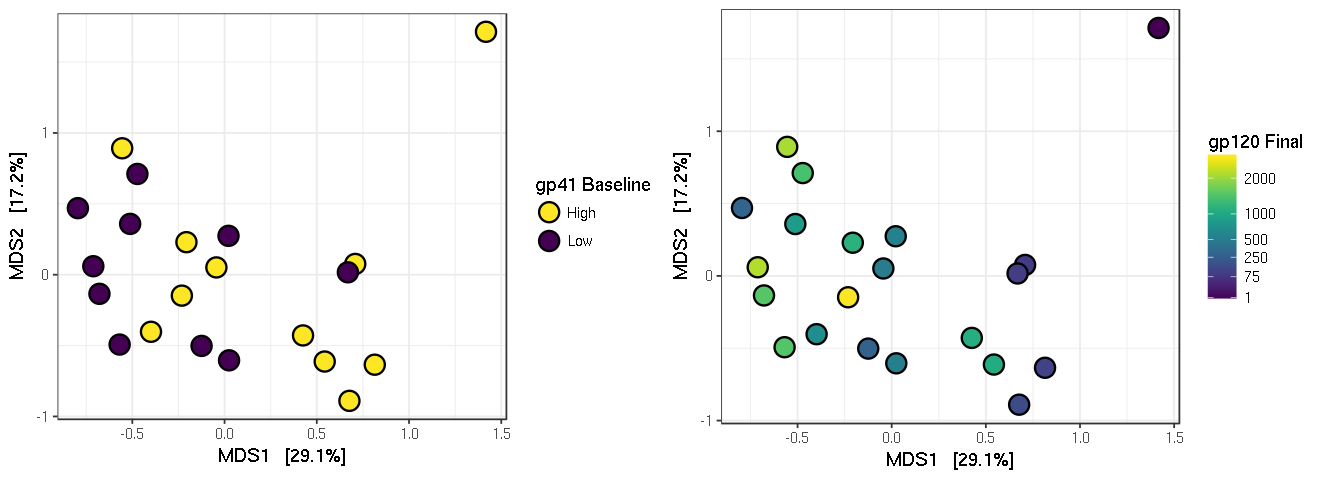

In [66]:
# Note the square-root scale for gp120
my_breaks = c(1, 75, 250, 500, 1000,2000)
wuford_gp41 <- plot_ordination(psN2 %>%
                           mutate_phyloseq_sample(
                               mc41 = factor(medcode_hl(IgG_gp41_Month_0)),
                                                log120 = (IgG_Con.6.gp120.B_Month_6.5)),
                 psN2.pcoa) + coord_fixed(sqrt(psN2.pcoa$CA$eig[2]/psN2.pcoa$CA$eig[1])) +
geom_point(aes(fill = mc41), size = 5, stroke = 1, shape = 21) + 
#scale_shape_manual(name = 'Sex', values = c(21, 24)) +
 viridis::scale_fill_viridis(name = 'gp41 Baseline', direction =-1, discrete = TRUE) +
#scale_fill_manual(name = 'gp41 Primary', values = c('orange', 'blue')) + 
theme_bw()

# Note the square-root scale for gp120

my_breaks = c(1, 75, 250, 500, 1000,2000)
wuford_gp120 <- plot_ordination(psN2 %>%
                           mutate_phyloseq_sample(
                               mc41 = factor(medcode_hl(IgG_gp41_Month_0)),
                                                log120 = (IgG_Con.6.gp120.B_Month_12)),
                 psN2.pcoa) + coord_fixed(sqrt(psN2.pcoa$CA$eig[2]/psN2.pcoa$CA$eig[1])) +
geom_point(aes(fill = log120), size = 5, stroke = 1, shape = 21) + 
viridis::scale_fill_viridis(name = 'gp120 Final', direction = 1, trans = "sqrt",
                           breaks = my_breaks, labels = my_breaks) +
#scale_colour_manual(name = 'gp41 Primary', values = c('black', 'grey70')) + 
theme_bw()

par <- options()
options(repr.plot.width=11, repr.plot.height= 4)
g <- grid.arrange(wuford_gp41, wuford_gp120, ncol = 2)
#g
ggsave('figures/wunifrac_Agp41_Bgp120_pcoa.png', g, width = 8, height = 4)

# Kernel Regression and Weighted Unifrac GLM

In [67]:
wufKN2 <- D2K(as.matrix(psN2.wuf))

In [68]:
muDoners <- unique(sample_data(psN2)$pub_id)

In [69]:
immune.data %>%
filter(pub_id %in% muDoners) %>%
filter(
    (type == 'IgG' & 
    antigen %in% ants1 &
    month %in% c(6.5,12)
    ) |
    (type %in% c('IgG', 'IgA') &
     antigen %in% ants2 &
     month %in% c(0,6.5,12)
    ) |
    type == 'CD4+' &
    antigen == 'ANY.ENV.PTEG' &
    month %in% c(6.5, 12)
      )-> use.immune
head(use.immune)

visitno,rx_code,type,antigen,mag,mag_bl,response,day,month,ct,response_j,assay,pub_id
9,T1,IgA,gp41,333.25,109.5,0,182,6.5,T,0.19882813,BAMA,282
12,T1,IgA,gp41,1.00,109.5,0,364,12.0,T,0.15338760,BAMA,282
9,T1,IgA,p24,658.00,329.8,0,182,6.5,T,-0.17841981,BAMA,282
12,T1,IgA,p24,862.20,329.8,0,364,12.0,T,-0.08504074,BAMA,282
9,T1,IgG,Con.6.gp120.B,27127.50,1.0,1,182,6.5,T,1.10518516,BAMA,282
12,T1,IgG,Con.6.gp120.B,1488.00,1.0,1,364,12.0,T,1.09794453,BAMA,282


In [70]:
# Do permanova and related tests to a variable of interest
# This function is pretty specific to this analysis, so I'm going to leave it
# here in the notebook file
CapVar <- function(x, nperm = 9999, transformation = medcode2, family = 'binomial'){
    ## Pull out the needed data
    
    psN2.wMDS <- psN2 %>% phylo_join(scores(psN2.pcoa, display = "sites", choices = 1:10) %>%
                    as.data.frame %>% rownames_to_column, by = 'rowname')
    
    medWuf <- NA
    rankWuf <- NA
    locPS <- phylo_join(psN2.wMDS, x, by = 'pub_id') 
    ydata0 <- sample_data(locPS)$mag
    yna <- is.na(ydata0)
    #loc.wuf <- wufKN2
    #loc.jsd <- jsdKN2
    ydata <- ydata0
    
    ydata <- ydata0[!yna]
    loc.wuf2 <- psN2.wuf %>% as.matrix %>% .[!yna, !yna]
    
    medWuf <- adonis(loc.wuf2 ~ transformation(ydata), permutations = nperm)
    #medWuf$aov.tab[1,c('R2', 'Pr(>F)')]
    
    ## Capscale returns the same results as adonis (permanova), but also gives some other interesting results
    
    medWufCap <- capscale(loc.wuf2 ~ transformation(ydata))
    capanova <- anova(medWufCap, permutations = nperm)
    
    samDf <- locPS %>% sample_data %>% as('data.frame') %>% rownames_to_column %>%
     left_join(
        vegan::scores(medWufCap, display = 'sites') %>% as.data.frame %>% dplyr::select(CAP1) %>%
        rownames_to_column, by = 'rowname') %>% .[!yna,]
    
#     # Is giving only positive results with CAP1, not sure why
#     glmAnova <- glm(medcode(ydata) ~  MDS1 + CAP1, data = samDf, family = 'binomial') %>% anova(test = "Chisq")
    loc_glm <- glm(transformation(ydata) ~  MDS1, data = samDf, family = family)
    glmAnova <- loc_glm %>% anova(test = "Chisq")
    #glmAnova['CAP1', 'Deviance']/out_capanova['NULL', 'Resid. Dev']
    
    ## check against mirkat
    loc.Kwuf2 <- wufKN2[!yna, !yna]
    mirkatP <- MiRKAT(y = transformation(ydata), Ks = loc.Kwuf2, out_type = "C", method = 'permutation', nperm = nperm)
    
    #list(medWuf, capanova, mirkatP)
    
    pred_pct <- predict(loc_glm, type = "response")
    pred_01 <- as.numeric(predict(loc_glm, type = "response") > 0.5)
    
    accuracy <- mean(transformation(ydata) == pred_01)
    
        null_glm <- update(loc_glm, ~1)

    # Canonical caluclation of McFadden's R2 for the GLM
    McFadden = 1- (logLik(loc_glm)/ logLik(null_glm))
    
    # A GLM of all weighted unifrac components
    
    
    data.frame(
        caps.P = capanova['Model', 'Pr(>F)'],
        adonisP = medWuf$aov.tab[1, 'Pr(>F)'],
        mir.P = mirkatP,
        caps.F = capanova['Model', 'F'],
        caps.R2 = medWufCap$CCA$tot.chi/medWufCap$tot.chi, 
        wuf1.P = glmAnova['MDS1', 'Pr(>Chi)'],
        wuf1.DR = glmAnova['MDS1', 'Deviance'] / glmAnova['NULL', 'Resid. Dev'],
        wuf1.McFadden = McFadden,
        accuracy,
        wuf1.coef = coef(loc_glm)[2]
        #cap1.P = glmAnova['CAP1', 'Pr(>Chi)'],
        #cap1.R2 = glmAnova['CAP1', 'Deviance'] / glmAnova['NULL', 'Resid. Dev']
    )
    }
    

In [71]:
use.immune %>%
filter(type == 'IgG' & antigen == 'gp41'& month == 0 & ct == 'T') -> test.immune1

In [72]:
# Just confirming that the function works before it goes in a giant loop. I'd delete this,
# but i'll just end up needing it again if I do.
ptm = proc.time()
tps <- CapVar(test.immune1, nperm = 9999, transformation = medcode, family = 'binomial')
proc.time() - ptm
tps

   user  system elapsed 
  3.996   0.032   4.032 

,caps.P,adonisP,mir.P,caps.F,caps.R2,wuf1.P,wuf1.DR,wuf1.McFadden,accuracy,wuf1.coef
MDS1,0.0499,0.0507,0.0456,1.843635,0.08845076,0.01454191,0.205444,0.205444,0.6666667,2.160527


In [73]:
use.immune %>%
filter(type == 'CD4+' & month == 6.5 & ct == 'T') -> test.immune.pteg

In [74]:
# Just confirming that the function works before it goes in a giant loop. I'd delete this,
# but i'll just end up needing it again if I do.
ptm = proc.time()
tps <- CapVar(test.immune.pteg, nperm = jnperm, transformation = medcode, family = 'binomial')
proc.time() - ptm
tps

   user  system elapsed 
 33.950   0.760  34.734 

,caps.P,adonisP,mir.P,caps.F,caps.R2,wuf1.P,wuf1.DR,wuf1.McFadden,accuracy,wuf1.coef
MDS1,0.24723,0.24695,0.24765,1.231637,0.06087679,0.1995347,0.05662489,0.05662489,0.5714286,-0.9754128


In [75]:
# Run above function against every relevant variable.
ptm <- proc.time()

use.immune %>% 
filter(ct == 'T') %>%
group_by(type, antigen, month) %>%
do(data.frame(CapVar(., nperm = jnperm))) -> permKernTable
permKernTable

proc.time() - ptm

type,antigen,month,caps.P,adonisP,mir.P,caps.F,caps.R2,wuf1.P,wuf1.DR,wuf1.McFadden,accuracy,wuf1.coef
CD4+,ANY.ENV.PTEG,6.5,0.24591,0.24647,0.25048,1.2316372,0.06087679,0.199534718,0.0566248928,0.0566248928,0.5714286,-0.9754128
CD4+,ANY.ENV.PTEG,12.0,0.24998,0.24797,0.24751,1.2255316,0.06374501,0.210899019,0.0564542507,0.0564542507,0.6000000,-0.9532295
IgA,gp41,0.0,0.95044,0.94990,0.95763,0.4489014,0.02308107,0.655882911,0.0068318094,0.0068318094,0.6190476,0.3273075
IgA,gp41,6.5,0.22130,0.22211,0.22673,1.2726945,0.06277875,0.152494741,0.0704334725,0.0704334725,0.5714286,-1.1000504
IgA,gp41,12.0,0.74964,0.75133,0.75314,0.6996390,0.03741457,0.871396691,0.0009452047,0.0009452047,0.4500000,-0.1201828
IgA,p24,0.0,0.90775,0.90801,0.90925,0.5215572,0.02671699,0.309636229,0.0355149830,0.0355149830,0.6190476,0.7662777
IgA,p24,6.5,0.91963,0.91660,0.92238,0.5064104,0.02596123,0.676523611,0.0059889311,0.0059889311,0.4761905,-0.3051297
IgA,p24,12.0,0.37775,0.37336,0.37868,1.0510126,0.05516833,0.378932251,0.0279220300,0.0279220300,0.6000000,-0.6676646
IgG,Con.6.gp120.B,6.5,0.00387,0.00350,0.00366,2.9388952,0.13395821,0.001617104,0.3420033673,0.3420033673,0.8571429,-3.1161660
IgG,Con.6.gp120.B,12.0,0.03182,0.03215,0.03147,2.0391949,0.09692362,0.009180327,0.2335286835,0.2335286835,0.7619048,-2.3083625


   user  system elapsed 
640.352   8.467 649.263 

The above function runs several extra tests. Results as follows:

type antigen visitno - things we run over

caps.P - Capscale test asks whether if we rotate things a bit and then try to use the best axis to compare to the data. Its similar to the wuf1.P value, but with some rotation

adonisP - p-value for a permanova test. Similar to mirkat p-value. One key exception is that igg_gp41_Month_0 falls on different sides of the 0.05 threshold.

mir.P is the p value for the kernel regression test, as run in the MiRKAT package. 
(Zhao et al., 2015)

caps.F and caps R2 are the f and r squared values for the capscale test.

wuf.P - is the p value of a glm comparing weighted unifrac component one against variables of interest. This test appears to always be statistically significantly positive when the mirkat test is positve.

wuf1.DR - one way of calculating an R2 value from a glm. We devide the deviance by the residual deviance

wuf1.McFadden - is a McFadden's pseudo R^2. This turns out to be identical to the previous calculation.

accuracy - the fraction of the time that the glm predicts something falls above or below the median correctly. This turns out to not be super informative. Everything has around a 60% accuracy.

wuf1.coef - the coefficient of the glm model. The sign is relevant. Things with postive sign are associated with high values of weighted unifrac axis 1.

In [196]:
# Clean up so we just see the results of the kernel regression 
concisePermKernTable <- permKernTable %>% ungroup %>%
mutate(Kernel_Q = p2q(mir.P), MDS1_Q = p2q(wuf1.P)) %>%
dplyr::select(Type = type, Antigen = antigen,Month = month, Kernel_P = mir.P, Kernel_Q,
              MDS1_P = wuf1.P, MDS1_Q, GlmMDS1_R2 = wuf1.McFadden, MDS1_Coef = wuf1.coef) %>%
as.data.frame %>% 
pass -> concisePermKernTable
write.csv(format(concisePermKernTable, digits = 3), 'tables/concisePermkernTable.csv')

### Table 1

In [197]:
# export conditionally formatted table as html

colNames1 = c(' ' = 3, 'Kernel' = 2, 'MDS' = 4)
colNames2 = c('Type', 'Antigen', 'Month', 'P', 'Q', 'P', 'Q', 'R2', 'Coef' )

concisePermKernTable %>%
mutate(
    # this row needs to happen first, since the reformatting of the nother numbers makes them harder to call
    MDS1_Coef = cell_spec(format(MDS1_Coef, digits = 3), "html",
                           color = ifelse(MDS1_P < 0.05, 
                                         ifelse(MDS1_Coef < 0, 'red', 'blue'),
                                         'black')),
    Kernel_P = cell_spec(format_round(Kernel_P, 3), "html",
                                  bold = ifelse(Kernel_P < 0.05, T, F),
                                  background = ifelse(Kernel_P < 0.05, 'yellow', '')
                                 ),
    Kernel_Q = cell_spec(format_round(Kernel_Q, 3), "html",
                                  bold = ifelse(Kernel_Q < 0.2, T, F),
                                  background = ifelse(Kernel_Q < 0.2, 'lightyellow', '')
                                 ),
     MDS1_P  = cell_spec(format_round(MDS1_P, 3), "html",
                                  bold = ifelse(MDS1_P < 0.05, T, F),
                                  background = ifelse(MDS1_P < 0.05, 'yellow', '')
                                 ),
    MDS1_Q = cell_spec(format_round(MDS1_Q, 3), "html",
                                  bold = ifelse(MDS1_Q < 0.2, T, F),
                                  background = ifelse(MDS1_Q < 0.2, 'lightyellow', '')
                                 ),
    #Month = cell_spec(format_round(Month,0), "html")
    Month = cell_spec(Month, "html")

    
      ) %>%
mutate(Antigen = gsub('ANY.ENV.PTEG', 'Any ENV PTEG', Antigen)) %>%
mutate(Antigen = gsub('gp70_B.CaseA_V1_V2', 'gp70 B.CaseA V1-V2', Antigen)) -> toTable

toTable %>%

kable("html", escape = F, digits = 3, align = 'c', col.names = colNames2) %>%
kable_styling("striped", "hover", full_width = F) %>%
add_header_above(colNames1) %>%
collapse_rows(columns = 1:2, latex_hline = "full") -> concisePermKernTable.html

concisePermKernTable.html %>% 
as.character() %>%
display_html()

concisePermKernTable.html %>% cat(file = 'tables/concisePermkernTable.html')

Kernel 
 MDS 
 
 
 Type 
 Antigen 
 Month 
 P 
 Q 
 P 
 Q 
 R2 
 Coef 
 
 
 
 
 CD4+ 
 Any ENV PTEG 
 6.5 
 0.250 
 0.477 
 0.200 
 0.048 
 0.057 
 -0.975 
 
 
 
 
 12 
 0.248 
 0.477 
 0.211 
 0.048 
 0.056 
 -0.953 
 
 
 IgA 
 gp41 
 0 
 0.958 
 0.958 
 0.656 
 0.093 
 0.007 
 0.327 
 
 
 
 
 6.5 
 0.227 
 0.477 
 0.152 
 0.045 
 0.070 
 -1.100 
 
 
 
 
 12 
 0.753 
 0.941 
 0.871 
 0.108 
 0.001 
 -0.120 
 
 
 
 p24 
 0 
 0.909 
 0.958 
 0.310 
 0.064 
 0.036 
 0.766 
 
 
 
 
 6.5 
 0.922 
 0.958 
 0.677 
 0.093 
 0.006 
 -0.305 
 
 
 
 
 12 
 0.379 
 0.583 
 0.379 
 0.069 
 0.028 
 -0.668 
 
 
 IgG 
 Con.6.gp120.B 
 6.5 
 0.004 
 0.073 
 0.002 
 0.004 
 0.342 
 -3.116 
 
 
 
 
 12 
 0.031 
 0.161 
 0.009 
 0.007 
 0.234 
 -2.308 
 
 
 
 gp41 
 0 
 0.047 
 0.162 
 0.015 
 0.007 
 0.205 
 2.161 
 
 
 
 
 6.5 
 0.049 
 0.162 
 0.032 
 0.013 
 0.158 
 -1.770 
 
 
 
 
 12 
 0.653 
 0.871 
 0.806 
 0.105 
 0.002 
 -0.179 
 
 
 
 gp70 B.CaseA V1-V2 
 6.5 
 0.886 
 0.958 
 0.599 
 0.093 
 0.010 
 -0.385 
 
 
 
 
 12 
 0.032 
 0.161 
 0.014 
 0.007 
 0.209 
 -2.138 
 
 
 
 p24 
 0 
 0.201 
 0.477 
 0.420 
 0.070 
 0.022 
 -0.597 
 
 
 
 
 6.5 
 0.431 
 0.615 
 0.389 
 0.069 
 0.027 
 -0.752 
 
 
 
 
 12 
 0.275 
 0.477 
 0.153 
 0.045 
 0.070 
 -1.098 
 
 
 
 ZM96.gp140 
 6.5 
 0.014 
 0.137 
 0.009 
 0.007 
 0.235 
 -2.317 
 
 
 
 
 12 
 0.286 
 0.477 
 0.164 
 0.045 
 0.067 
 -1.067

Latex version of the same table

In [198]:

docHead <- "\\documentclass[12pt]{article} % use larger type; default would be 10pt

\\usepackage[utf8]{inputenc} % set input encoding (not needed with XeLaTeX)
\\usepackage{booktabs}
\\usepackage{longtable}
\\usepackage{array}
\\usepackage{multirow}
\\usepackage[table]{xcolor}
\\usepackage{wrapfig}
\\usepackage{float}
\\usepackage{colortbl}
\\usepackage{pdflscape}
\\usepackage{tabu}
\\usepackage{threeparttable}
\\usepackage{threeparttablex}
\\usepackage[normalem]{ulem}
\\usepackage{makecell}

\\definecolor{green}{rgb}{1, 1, .9}

\\begin{document}
"

docTail <- "\\end{document}
"

In [199]:
# Make latex table

concisePermKernTable %>%
mutate(
    # this row needs to happen first, since the reformatting of the nother numbers makes them harder to call
    MDS1_Coef = cell_spec(format(MDS1_Coef, digits = 3), "latex",
                           color = ifelse(MDS1_P < 0.05, 
                                         ifelse(MDS1_Coef < 0, 'red', 'blue'),
                                         'black')),
    Kernel_P = cell_spec(format_round(Kernel_P, 3), "latex",
                                  bold = ifelse(Kernel_P < 0.05, T, F),
                                  background = ifelse(Kernel_P < 0.05, 'yellow', 'white')
                                 ),
    Kernel_Q = cell_spec(format_round(Kernel_Q, 3), "latex",
                                  bold = ifelse(Kernel_Q < 0.2, T, F),
                                  background = ifelse(Kernel_Q < 0.2, 'green', 'white')
                                 ),
     MDS1_P  = cell_spec(format_round(MDS1_P, 3), "latex",
                                  bold = ifelse(MDS1_P < 0.05, T, F),
                                  background = ifelse(MDS1_P < 0.05, 'yellow', 'white')
                                 ),
    MDS1_Q = cell_spec(format_round(MDS1_Q, 3), "latex",
                                  bold = ifelse(MDS1_Q < 0.2, T, F),
                                  background = ifelse(MDS1_Q < 0.2, 'green', 'white')
                                 ),
    #Month = cell_spec(format_round(Month,0), "html")
    Month = cell_spec(Month, "latex")

    
      ) %>%
mutate(Antigen = gsub('ANY.ENV.PTEG', 'Any ENV PTEG', Antigen)) %>%
mutate(Antigen = gsub('gp70_B.CaseA_V1_V2', 'gp70 B.CaseA V1-V2', Antigen)) -> toTable

toTable %>% 
kable("latex", escape = F, digits = 3, align = 'c', col.names = colNames2, booktabs = T) %>%
kable_styling(position = "left") %>%

add_header_above(colNames1) %>%
collapse_rows(columns = 1:2, latex_hline = "full") %>%
pass -> concisePermKernTable.tex

In [200]:
# Print latex table to tex file

cat(docHead, concisePermKernTable.tex, docTail, file = 'tables/concisePermkernTable1.tex')

In [184]:
concisePermKernTable %>% filter(Kernel_P < 0.05) -> shortPermkernTable
shortPermkernTable
write.csv(format(shortPermkernTable, digits = 3), 'tables/shortPermkernTable.csv')

Type,Antigen,Month,Kernel_P,Kernel_Q,MDS1_P,MDS1_Q,MDS1_R2,MDS1_Coef
IgG,Con.6.gp120.B,12.0,0.00042,0.0084000,1.182113e-05,7.624075e-05,0.0741095712,-3.179778e+01
IgG,p24,6.5,0.02902,0.1934667,5.692922e-02,6.413855e-02,0.0009790688,-9.309477e+39
IgG,ZM96.gp140,6.5,0.02625,0.1934667,1.783694e-02,5.751993e-02,0.0873953957,-8.474126e-01


## As above, but this time with gaussian - continuous dependent variables

In [83]:
ptm = proc.time()
tps <- CapVar(test.immune1, nperm = 999, transformation = function(x){jac_box_cox(x)}, family = 'gaussian')
proc.time() - ptm
tps

   user  system elapsed 
  0.696   0.012   0.709 

,caps.P,adonisP,mir.P,caps.F,caps.R2,wuf1.P,wuf1.DR,wuf1.McFadden,accuracy,wuf1.coef
MDS1,0.261,0.24,0.229,1.26187,0.06227805,0.03957279,0.1823071,0.06051405,0,0.9093061


In [84]:
# Run above function against every relevant variable.
ptm <- proc.time()

use.immune %>%
filter(ct == 'T') %>%
group_by(type, antigen, month) %>%
do(data.frame(CapVar(., nperm = jnperm,
                     transformation = function(x){jac_box_cox(x)},
                     family = 'gaussian'))) -> permKernTableGaus
permKernTableGaus

proc.time() - ptm

type,antigen,month,caps.P,adonisP,mir.P,caps.F,caps.R2,wuf1.P,wuf1.DR,wuf1.McFadden,accuracy,wuf1.coef
CD4+,ANY.ENV.PTEG,6.5,0.60019,0.60184,0.60630,0.8212809,0.04143430,5.792023e-01,0.015927778,0.0058914665,0.00000000,-1.990440e-01
CD4+,ANY.ENV.PTEG,12.0,0.19968,0.20179,0.19319,1.3330405,0.06895142,3.044964e-01,0.055336185,0.0212048318,0.00000000,-3.547800e-01
IgA,gp41,0.0,0.98847,0.98892,0.99057,0.2956250,0.01532083,6.289317e-01,0.012140901,0.0028124048,0.00000000,3.902553e-01
IgA,gp41,6.5,0.44523,0.44760,0.45143,0.9591736,0.04805678,6.287404e-01,0.012154285,0.0032169140,0.00000000,-2.977883e-01
IgA,gp41,12.0,0.64589,0.64204,0.65072,0.7582985,0.04042469,4.888847e-01,0.025920264,0.0065516637,0.00000000,4.795132e-01
IgA,p24,0.0,0.95875,0.95769,0.95684,0.3928376,0.02025684,4.292118e-01,0.031844923,-0.0084175149,0.00000000,1.053733e-02
IgA,p24,6.5,0.97574,0.97582,0.97798,0.3594980,0.01856959,8.824867e-01,0.001148681,0.0003173815,0.00000000,-8.366452e-02
IgA,p24,12.0,0.55791,0.55340,0.55672,0.8668668,0.04594651,3.106650e-01,0.054018011,0.0186198457,0.00000000,-4.144213e-01
IgG,Con.6.gp120.B,6.5,0.06216,0.06015,0.05918,1.8162378,0.08725101,2.802032e-02,0.202579164,0.0106770422,0.00000000,-7.299531e+03
IgG,Con.6.gp120.B,12.0,0.00056,0.00048,0.00042,3.6945126,0.16279321,1.182113e-05,0.502512860,0.0741095712,0.00000000,-3.179778e+01


   user  system elapsed 
595.789   3.303 599.703 

In [185]:
# Clean up so we just see the results of the kernel regression 
concisePermKernTable <- permKernTableGaus %>% ungroup %>%
mutate(Kernel_Q = p2q(mir.P), MDS1_Q = p2q(wuf1.P)) %>%
dplyr::select(Type = type, Antigen = antigen, Month = month, Kernel_P = mir.P, Kernel_Q,
              MDS1_P = wuf1.P, MDS1_Q, MDS1_R2 = wuf1.McFadden, MDS1_Coef = wuf1.coef) %>%
as.data.frame %>% 
pass -> concisePermKernTableGaus

concisePermKernTableGaus

write.csv(format(concisePermKernTableGaus, digits = 3), 'tables/concisePermkernTableGaus.csv')

Type,Antigen,Month,Kernel_P,Kernel_Q,MDS1_P,MDS1_Q,MDS1_R2,MDS1_Coef
CD4+,ANY.ENV.PTEG,6.5,0.60630,0.8084000,5.792023e-01,2.253508e-01,0.0058914665,-1.990440e-01
CD4+,ANY.ENV.PTEG,12.0,0.19319,0.4964667,3.044964e-01,1.541264e-01,0.0212048318,-3.547800e-01
IgA,gp41,0.0,0.99057,0.9905700,6.289317e-01,2.253508e-01,0.0028124048,3.902553e-01
IgA,gp41,6.5,0.45143,0.6945077,6.287404e-01,2.253508e-01,0.0032169140,-2.977883e-01
IgA,gp41,12.0,0.65072,0.8134000,4.888847e-01,2.102051e-01,0.0065516637,4.795132e-01
IgA,p24,0.0,0.95684,0.9905700,4.292118e-01,1.977296e-01,-0.0084175149,1.053733e-02
IgA,p24,6.5,0.97798,0.9905700,8.824867e-01,2.965122e-01,0.0003173815,-8.366452e-02
IgA,p24,12.0,0.55672,0.7953143,3.106650e-01,1.541264e-01,0.0186198457,-4.144213e-01
IgG,Con.6.gp120.B,6.5,0.05918,0.2959000,2.802032e-02,6.023930e-02,0.0106770422,-7.299531e+03
IgG,Con.6.gp120.B,12.0,0.00042,0.0084000,1.182113e-05,7.624075e-05,0.0741095712,-3.179778e+01


### Table S1

In [186]:
# export conditionally formatted table as html
concisePermKernTableGaus %>%
mutate(
    # this row needs to happen first, since the reformatting of the nother numbers makes them harder to call
    MDS1_Coef = cell_spec(format(MDS1_Coef, digits = 3), "html",
                           color = ifelse(MDS1_P < 0.05, 
                                         ifelse(MDS1_Coef < 0, 'red', 'blue'),
                                         'black')),
    Kernel_P = cell_spec(format_round(Kernel_P, 3), "html",
                                  bold = ifelse(Kernel_P < 0.05, T, F),
                                  background = ifelse(Kernel_P < 0.05, 'yellow', '')
                                 ),
    Kernel_Q = cell_spec(format_round(Kernel_Q, 3), "html",
                                  bold = ifelse(Kernel_Q < 0.2, T, F),
                                  background = ifelse(Kernel_Q < 0.2, 'lightyellow', '')
                                 ),
     MDS1_P  = cell_spec(format_round(MDS1_P, 3), "html",
                                  bold = ifelse(MDS1_P < 0.05, T, F),
                                  background = ifelse(MDS1_P < 0.05, 'yellow', '')
                                 ),
    MDS1_Q = cell_spec(format_round(MDS1_Q, 3), "html",
                                  bold = ifelse(MDS1_Q < 0.2, T, F),
                                  background = ifelse(MDS1_Q < 0.2, 'lightyellow', '')
                                 ),
    Month = cell_spec(Month, "html")

    
      ) %>%
kable("html", escape = F, digits = 3, align = 'c') %>%
as.character() -> concisePermKernTableGaus.html

concisePermKernTableGaus.html %>% 
display_html() %>%
cat(file = 'tables/concisePermkernTableGaus.html')

Type,Antigen,Month,Kernel_P,Kernel_Q,MDS1_P,MDS1_Q,MDS1_R2,MDS1_Coef
CD4+,ANY.ENV.PTEG,6.5,0.606,0.808,0.579,0.225,0.006,-1.99e-01
CD4+,ANY.ENV.PTEG,12,0.193,0.496,0.304,0.154,0.021,-3.55e-01
IgA,gp41,0,0.991,0.991,0.629,0.225,0.003,3.90e-01
IgA,gp41,6.5,0.451,0.695,0.629,0.225,0.003,-2.98e-01
IgA,gp41,12,0.651,0.813,0.489,0.210,0.007,4.80e-01
IgA,p24,0,0.957,0.991,0.429,0.198,-0.008,1.05e-02
IgA,p24,6.5,0.978,0.991,0.882,0.297,0.000,-8.37e-02
IgA,p24,12,0.557,0.795,0.311,0.154,0.019,-4.14e-01
IgG,Con.6.gp120.B,6.5,0.059,0.296,0.028,0.060,0.011,-7.30e+03
IgG,Con.6.gp120.B,12,0.000,0.008,0.000,0.000,0.074,-3.18e+01


In [187]:
concisePermKernTableGaus %>% filter(Kernel_P < 0.05) -> shortPermkernTableGaus
shortPermkernTableGaus
write.csv(format(shortPermkernTableGaus, digits = 3), 'tables/shortPermkernTable.csv')

Type,Antigen,Month,Kernel_P,Kernel_Q,MDS1_P,MDS1_Q,MDS1_R2,MDS1_Coef
IgG,Con.6.gp120.B,12.0,0.00042,0.0084000,1.182113e-05,7.624075e-05,0.0741095712,-3.179778e+01
IgG,p24,6.5,0.02902,0.1934667,5.692922e-02,6.413855e-02,0.0009790688,-9.309477e+39
IgG,ZM96.gp140,6.5,0.02625,0.1934667,1.783694e-02,5.751993e-02,0.0873953957,-8.474126e-01


In [193]:
# Make latex table

concisePermKernTableGaus %>%
mutate(
    # this row needs to happen first, since the reformatting of the nother numbers makes them harder to call
    MDS1_Coef = cell_spec(format(MDS1_Coef, digits = 3), "latex",
                           color = ifelse(MDS1_P < 0.05, 
                                         ifelse(MDS1_Coef < 0, 'red', 'blue'),
                                         'black')),
    Kernel_P = cell_spec(format_round(Kernel_P, 3), "latex",
                                  bold = ifelse(Kernel_P < 0.05, T, F),
                                  background = ifelse(Kernel_P < 0.05, 'yellow', 'white')
                                 ),
    Kernel_Q = cell_spec(format_round(Kernel_Q, 3), "latex",
                                  bold = ifelse(Kernel_Q < 0.2, T, F),
                                  background = ifelse(Kernel_Q < 0.2, 'green', 'white')
                                 ),
     MDS1_P  = cell_spec(format_round(MDS1_P, 3), "latex",
                                  bold = ifelse(MDS1_P < 0.05, T, F),
                                  background = ifelse(MDS1_P < 0.05, 'yellow', 'white')
                                 ),
    MDS1_Q = cell_spec(format_round(MDS1_Q, 3), "latex",
                                  bold = ifelse(MDS1_Q < 0.2, T, F),
                                  background = ifelse(MDS1_Q < 0.2, 'green', 'white')
                                 ),
    #Month = cell_spec(format_round(Month,0), "html")
    Month = cell_spec(Month, "latex")

    
      ) %>%
mutate(Antigen = gsub('ANY.ENV.PTEG', 'Any ENV PTEG', Antigen)) %>%
mutate(Antigen = gsub('gp70_B.CaseA_V1_V2', 'gp70 B.CaseA V1-V2', Antigen)) -> toTable

toTable %>% 
kable("latex", escape = F, digits = 3, align = 'c', col.names = colNames2, booktabs = T) %>%
kable_styling(position = "left") %>%

add_header_above(colNames1) %>%
collapse_rows(columns = 1:2, latex_hline = "full") %>%
pass -> concisePermKernTableGaus.tex

In [194]:
# Print latex table to tex file

cat(docHead, concisePermKernTableGaus.tex, docTail, file = 'tables/concisePermkernTableGaus.tex')

## Chi Squared test for statistical associations between each pair of immune variables

In [90]:
use.immune %>% dplyr::select(pub_id, visitno, type, antigen, mag) -> tmp
full_join(tmp, tmp, by = 'pub_id') %>% 
group_by(visitno.x, type.x, antigen.x, visitno.y, type.y, antigen.y) %>%
nest %>%
mutate(x2 = map(data, function(df){unwarn(chisq.test(df$mag.x, df$mag.y))})) %>%
mutate(glance = map(x2, glance)) %>%
dplyr::select(-data, -x2) %>%
unnest(glance) %>%
#mutate(q.value = p2q(p.value)) %>% # reurns NaNs
pass -> compareImmuneX2

In [91]:
compareImmuneX2 %>% filter(
    type.x == 'IgG' &
    antigen.x == 'gp41' &
    type.y == 'IgG' &
    antigen.y == 'gp41'
)

visitno.x,type.x,antigen.x,visitno.y,type.y,antigen.y,statistic,p.value,parameter,method
9,IgG,gp41,9,IgG,gp41,420,0.23603033,400,Pearson's Chi-squared test
9,IgG,gp41,12,IgG,gp41,378,0.24676604,360,Pearson's Chi-squared test
9,IgG,gp41,2,IgG,gp41,420,0.23603033,400,Pearson's Chi-squared test
12,IgG,gp41,9,IgG,gp41,378,0.24676604,360,Pearson's Chi-squared test
12,IgG,gp41,12,IgG,gp41,378,0.02069535,324,Pearson's Chi-squared test
12,IgG,gp41,2,IgG,gp41,378,0.24676604,360,Pearson's Chi-squared test
2,IgG,gp41,9,IgG,gp41,420,0.23603033,400,Pearson's Chi-squared test
2,IgG,gp41,12,IgG,gp41,378,0.24676604,360,Pearson's Chi-squared test
2,IgG,gp41,2,IgG,gp41,420,0.23603033,400,Pearson's Chi-squared test


In [92]:
compareImmuneX2 %>%
filter(type.x == 'IgG' & type.y == 'IgG' & antigen.x != antigen.y) %>%
write_csv('tables/chisq_IgG_comparasons.csv')

# MDS GLM for each other MDS Axis

In [93]:
psN2 %>% phylo_join(scores(psN2.pcoa, display = "sites", choices = 1:10) %>%
                    as.data.frame %>% rownames_to_column, by = 'rowname') %>%
sample_data %>% as('data.frame') %>% rownames_to_column -> hereSam


In [94]:
data_frame(formula = paste("transformation(ydata) ~ MDS", 1:10, sep = ""))

formula
transformation(ydata) ~ MDS1
transformation(ydata) ~ MDS2
transformation(ydata) ~ MDS3
transformation(ydata) ~ MDS4
transformation(ydata) ~ MDS5
transformation(ydata) ~ MDS6
transformation(ydata) ~ MDS7
transformation(ydata) ~ MDS8
transformation(ydata) ~ MDS9
transformation(ydata) ~ MDS10


In [95]:
EachMDS <- function(x, nperm = 9999, transformation = medcode2, family = 'binomial'){
    ## Pull out the needed data
    
    psN2.wMDS <- psN2 %>% phylo_join(scores(psN2.pcoa, display = "sites", choices = 1:10) %>%
                    as.data.frame %>% rownames_to_column, by = 'rowname')
    
#     medWuf <- NA
#     rankWuf <- NA
    locPS <- phylo_join(psN2.wMDS, x, by = 'pub_id') 
    ydata0 <- sample_data(locPS)$mag
    yna <- is.na(ydata0)
    #loc.wuf <- wufKN2
    #loc.jsd <- jsdKN2
    ydata <- ydata0
    
    ydata <- ydata0[!yna]
    loc.wuf2 <- psN2.wuf %>% as.matrix %>% .[!yna, !yna]
    
     samDf <- locPS %>% sample_data %>% as('data.frame') %>% rownames_to_column %>%
    .[!yna,]

#     # Is giving only positive results with CAP1, not sure why
    loc_glm <- glm(as.formula("transformation(ydata) ~  MDS1"), data = samDf, family = family)
    glmAnova <- loc_glm %>% anova(test = "Chisq")
    
    # data_frame, rather than data.frame
    # https://stackoverflow.com/questions/48450308/iterating-over-formulas-in-purrr#48450308
    data_frame(formulaString = paste("transformation(ydata) ~ MDS", 1:10, sep = "")) %>%
     mutate(model = map(formulaString, function(fs){
         glm(as.formula(fs), data = samDf, family = family)})) %>%
    mutate(anova = map(model, anova)) %>%
    mutate(glance = map(model, glance)) %>%
    mutate(tidy = map(model, tidy)) %>%
    mutate(coef = map(model, ~ coef(summary(.))[2,])) %>%
    pass -> allmodels

    allmodels %>% dplyr::select("tidy") %>% unnest %>% filter(term != '(Intercept)')
    
 
    }
    

In [96]:
# Just confirming that the function works before it goes in a giant loop. I'd delete this,
# but i'll just end up needing it again if I do.
ptm = proc.time()
tps <- EachMDS(test.immune.pteg, nperm = 9999, transformation = medcode, family = 'binomial')
proc.time() - ptm

   user  system elapsed 
  0.447   0.000   0.447 

In [97]:
tps

term,estimate,std.error,statistic,p.value
MDS1,-0.9754128,0.7940833,-1.2283508,0.21931532
MDS2,0.3728636,0.7506141,0.4967448,0.61936906
MDS3,0.2332130,0.7318023,0.3186830,0.74996690
MDS4,-0.9790495,0.8155394,-1.2004932,0.22994785
MDS5,-1.4140374,0.9575616,-1.4767064,0.13975435
MDS6,1.6148495,0.9477460,1.7038843,0.08840271
MDS7,-0.4174758,0.7425212,-0.5622410,0.57395186
MDS8,1.7644362,1.0613061,1.6625140,0.09640976
MDS9,0.3521472,0.7404089,0.4756118,0.63435096
MDS10,0.8569519,0.8016224,1.0690219,0.28505979


In [98]:
use.immune %>%
group_by(type, antigen, month) %>%
nest %>%
mutate(coefs = map(data, ~ EachMDS(.))) %>%
dplyr::select(-data) %>% unnest(coefs) -> glmMDScoefs

In [99]:
glmMDScoefs %>%
gather(key = "key", value = "value", estimate:p.value) %>%
filter(key == "p.value") %>%
spread(key = term, value = value) %>%
dplyr::select(-key, -MDS10, MDS10) %>%
mutate(type = factor(type, levels = c( "IgA", "IgG",  "CD4+"))) %>%
mutate(antigen = factor(antigen, levels = c(ants1, ants2, "ANY.ENV.PTEG"))) %>%
arrange(type) -> allMDS
allMDS

type,antigen,month,MDS1,MDS2,MDS3,MDS4,MDS5,MDS6,MDS7,MDS8,MDS9,MDS10
IgA,gp41,0.0,0.65799433,0.5790607,0.4028779,0.8287783,0.70014966,0.65603300,0.20962299,0.43176401,0.04094774,0.84043068
IgA,gp41,6.5,0.17530332,0.3706277,0.7550858,0.5557380,0.12195706,0.19556122,0.42787602,0.37736584,0.90540480,0.93455992
IgA,gp41,12.0,0.87149360,0.2074865,0.4396120,0.3898685,0.81880133,0.75058308,0.61014154,0.11060043,0.10374374,0.16571849
IgA,p24,0.0,0.32472834,0.6900251,0.5699739,0.9520226,0.80647855,0.57120306,0.14077469,0.94004121,0.98051559,0.53072087
IgA,p24,6.5,0.67776125,0.2970636,0.6774744,0.3099132,0.63984334,0.62236668,0.93368348,0.21445005,0.89139811,0.34050424
IgA,p24,12.0,0.38953887,0.6829873,0.2588043,0.4465560,0.07901722,0.50064633,0.60754361,0.15567648,0.63011279,0.12866937
IgG,Con.6.gp120.B,6.5,0.01709165,0.6154469,0.3662748,0.6901515,0.32770209,0.49290032,0.85893782,0.68520295,0.72403914,0.20771686
IgG,Con.6.gp120.B,12.0,0.02980683,0.9821928,0.3502959,0.6741181,0.96472069,0.55854358,0.51249217,0.36222538,0.75314678,0.25977120
IgG,gp41,0.0,0.03961043,0.9101803,0.3689531,0.8099772,0.37454614,0.20949907,0.58838804,0.63131045,0.87321384,0.44972892
IgG,gp41,6.5,0.05803785,0.2655950,0.2681110,0.9179972,0.71447311,0.14393687,0.66999931,0.41701372,0.17862407,0.66594016


In [100]:
allMDS %>%
kable("html", escape = F, digits = 3, align = 'c') %>%
as.character() -> allMDS.html

allMDS.html %>% 
display_html()

allMDS.html %>% cat(file = 'tables/allMDS.html')

type,antigen,month,MDS1,MDS2,MDS3,MDS4,MDS5,MDS6,MDS7,MDS8,MDS9,MDS10
IgA,gp41,0.0,0.658,0.579,0.403,0.829,0.700,0.656,0.210,0.432,0.041,0.840
IgA,gp41,6.5,0.175,0.371,0.755,0.556,0.122,0.196,0.428,0.377,0.905,0.935
IgA,gp41,12.0,0.871,0.207,0.440,0.390,0.819,0.751,0.610,0.111,0.104,0.166
IgA,p24,0.0,0.325,0.690,0.570,0.952,0.806,0.571,0.141,0.940,0.981,0.531
IgA,p24,6.5,0.678,0.297,0.677,0.310,0.640,0.622,0.934,0.214,0.891,0.341
IgA,p24,12.0,0.390,0.683,0.259,0.447,0.079,0.501,0.608,0.156,0.630,0.129
IgG,Con.6.gp120.B,6.5,0.017,0.615,0.366,0.690,0.328,0.493,0.859,0.685,0.724,0.208
IgG,Con.6.gp120.B,12.0,0.030,0.982,0.350,0.674,0.965,0.559,0.512,0.362,0.753,0.260
IgG,gp41,0.0,0.040,0.910,0.369,0.810,0.375,0.209,0.588,0.631,0.873,0.450
IgG,gp41,6.5,0.058,0.266,0.268,0.918,0.714,0.144,0.670,0.417,0.179,0.666


In [101]:
write_csv(allMDS, 'tables/allMDSGlmPValues.csv')

# Jensen Shannon Kernel Regression
at each taxonomic level

## Agglomeration

In [102]:
# How many taxa do we see if we agglomerate at different levels
psN2 %>% tax_table %>% as.data.frame %>% dplyr::select(Phylum:Genus) %>% colnames -> taxLevels

data_frame(taxLevels) %>%
mutate(ntaxa = map(taxLevels,
    function(lev){
        psN2 %>% tax_glom(lev) %>% ntaxa
    }
                                             )) %>%
mutate(ntaxa = unlist(ntaxa)) %>%
pass -> NTaxaAtLevel
NTaxaAtLevel

taxLevels,ntaxa
Phylum,5
Class,12
Order,17
Family,36
Genus,90


In [103]:
data_frame(taxLevels = "Species", ntaxa = ntaxa(psN2), ps = list((psN2))) -> specRow
data_frame(taxLevels = "Species", ntaxa = ntaxa(psN1), psCount = list((psN1))) -> specRowC

In [104]:
D2K_savename <- function(distmat){
    # cascade names forward with the D2K operation
    require(MiRKAT)
    out <- MiRKAT::D2K(distmat)
    colnames(out) <- colnames(distmat)
    rownames(out) <- rownames(distmat)
    out
}

In [105]:
# Data frame of phyloseq objects distances and kernels at a bunch of taxonomic levels
NTaxaAtLevel %>%
mutate(ps = map(ntaxa, ~tip_glom_saveid(psN2, k = .))) %>%
# process the phyloseq objects so they have better names
mutate(ps = map(ps, ~swap.phyloseq.taxnames(tag_phyloseq(remove_tag_phyloseq(.)), oldname = 'oldname2'))) %>%
# add in the species data row (which should already have correct names)
bind_rows(specRow) %>%
# calculate jensen-shannon distance matrix
mutate(jsd = map(ps, ~phyloseq::distance(., method = "jsd") )) %>%
# convert to 2d matrix
mutate(jsdMat = map(jsd, ~as.matrix(.))) %>%
# calculate kernel
mutate(kjsd = map(jsdMat, ~D2K_savename(.))) -> tmp

tmp %>%
mutate(psNoZero = map(ps, ~transform_sample_counts(., function(x) x+(1/1000)))) -> tmp

tmp %>%
## chemometrics::clr just works, while compositions::clr throws a criptic error message here
mutate(clr = map(psNoZero, ~ transform_otu_table(., chemometrics::clr))) %>%
#mutate(clr = map(psNoZero, ~ transform_otu_table(., function(x) as.matrix(compositions::clr(x))))) %>%
pass -> psDf0 # Original way

Loading required package: cluster
Warning message:
“Setting row names on a tibble is deprecated.”Warning message:
“Setting row names on a tibble is deprecated.”Warning message:
“Setting row names on a tibble is deprecated.”Warning message:
“Setting row names on a tibble is deprecated.”Warning message:
“Setting row names on a tibble is deprecated.”

In [106]:
# Data frame of phyloseq objects distances and kernels at a bunch of taxonomic levels
# I use psN1 because I need count data for some downstream steps.
NTaxaAtLevel %>%
mutate(psCount = map(ntaxa, ~tip_glom_saveid(psN1, k = .))) %>%
# process the phyloseq objects so they have better names
mutate(psCount = map(psCount, ~swap.phyloseq.taxnames(tag_phyloseq(remove_tag_phyloseq(.)), oldname = 'oldname2'))) %>%
# add in the species data row (which should already have correct names)
bind_rows(specRowC) %>%
pass -> tmp

Warning message:
“Setting row names on a tibble is deprecated.”Warning message:
“Setting row names on a tibble is deprecated.”Warning message:
“Setting row names on a tibble is deprecated.”Warning message:
“Setting row names on a tibble is deprecated.”Warning message:
“Setting row names on a tibble is deprecated.”

In [107]:
tmp %>%
# calculate jensen-shannon distance matrix
mutate(ps = map(psCount, ~transform_sample_counts(., function(x) {x/sum(x)}))) %>%
mutate(jsd = map(ps, ~phyloseq::distance(., method = "jsd") )) %>%
# convert to 2d matrix
mutate(jsdMat = map(jsd, ~as.matrix(.))) %>%
# calculate kernel
mutate(kjsd = map(jsdMat, ~D2K_savename(.))) -> tmp

tmp %>%
mutate(psNoZero = map(ps, ~transform_sample_counts(., function(x) x+(1/1000)))) %>%
## chemometrics::clr just works, while compositions::clr throws a criptic error message here
mutate(clr = map(psNoZero, ~ transform_otu_table(., chemometrics::clr))) %>%
#mutate(clr = map(psNoZero, ~ transform_otu_table(., function(x) as.matrix(compositions::clr(x))))) %>%
pass -> psDf

In [108]:
print(psDf)

# A tibble: 6 x 9
  taxLevels ntaxa psCount        ps      jsd    jsdMat   kjsd   psNoZero clr   
  <chr>     <int> <list>         <list>  <list> <list>   <list> <list>   <list>
1 Phylum        5 <S4: phyloseq> <S4: p… <S3: … <dbl [2… <dbl … <S4: ph… <S4: …
2 Class        12 <S4: phyloseq> <S4: p… <S3: … <dbl [2… <dbl … <S4: ph… <S4: …
3 Order        17 <S4: phyloseq> <S4: p… <S3: … <dbl [2… <dbl … <S4: ph… <S4: …
4 Family       36 <S4: phyloseq> <S4: p… <S3: … <dbl [2… <dbl … <S4: ph… <S4: …
5 Genus        90 <S4: phyloseq> <S4: p… <S3: … <dbl [2… <dbl … <S4: ph… <S4: …
6 Species     536 <S4: phyloseq> <S4: p… <S3: … <dbl [2… <dbl … <S4: ph… <S4: …


In [109]:
MirMulti <- function(x, KsDf = psDf, ps = psN2, nperm = 9999){
    
    Ks = KsDf$kjsd
    
    # I  bind to the phyloseq object and then peel off again later to guerentee
    # that the y-data is in the same order as the Ks
    locPS <- phylo_join(ps, x, by = 'pub_id')
    
    ydata0 <- sample_data(locPS)$mag
    yna <- is.na(ydata0)

    ydata <- ydata0[!yna]
    loc.Ks <- lapply(Ks, function(K){K[!yna, !yna]})  
  
    bcxJSD <- MiRKAT(y = jac_box_cox(ydata), Ks = loc.Ks, out_type = "C", method = 'permutation', nperm = nperm)
    medJSD <- MiRKAT(y = medcode(ydata), Ks = loc.Ks, out_type = "D", method = 'permutation', nperm = nperm)
    mmDf = data.frame(
        taxLevels = KsDf$taxLevels,
        ntaxa = KsDf$ntaxa,
        bcxJSD = bcxJSD$indivP, medJSD = medJSD$indivP,
        bcxJSDOmni = bcxJSD$omnibus_p, medJSDOmni = medJSD$omnibus_p)
    mmDf
    
    }

In [110]:
# Test case

use.immune %>%
filter(type == 'IgG' & antigen == 'gp41'& visitno == 2 & ct == 'T') -> test.immune1

test.mm <- MirMulti(test.immune1, Ks = psDf, nperm = 999)

test.mm

taxLevels,ntaxa,bcxJSD,medJSD,bcxJSDOmni,medJSDOmni
Phylum,5,0.233,0.261,0.3285,0.0515
Class,12,0.644,0.601,0.3285,0.0515
Order,17,0.123,0.015,0.3285,0.0515
Family,36,0.154,0.019,0.3285,0.0515
Genus,90,0.267,0.027,0.3285,0.0515
Species,536,0.521,0.138,0.3285,0.0515


In [111]:
ptm = proc.time()

use.immune %>%
group_by(type, antigen, month) %>%
nest %>%
mutate(mir = map(data,
    ~MirMulti(., Ks = psDf, ps = psN2, nperm = 999)
)) %>%
dplyr::select(-data) %>% unnest(mir) %>%
pass -> mirLevels

proc.time() - ptm

   user  system elapsed 
  8.408   0.016   8.428 

In [112]:
mirLevels %>% dplyr::select(-ntaxa, -medJSD) %>% spread(key = taxLevels, value = bcxJSD)

type,antigen,month,bcxJSDOmni,medJSDOmni,Class,Family,Genus,Order,Phylum,Species
CD4+,ANY.ENV.PTEG,6.5,0.8430,0.4115,0.687,0.489,0.661,0.578,0.849,0.933
CD4+,ANY.ENV.PTEG,12.0,0.2705,0.3905,0.103,0.136,0.144,0.136,0.926,0.165
IgA,gp41,0.0,0.9970,0.9040,0.894,0.870,0.915,0.868,0.984,0.982
IgA,gp41,6.5,0.3105,0.3960,0.525,0.555,0.401,0.575,0.115,0.730
IgA,gp41,12.0,0.5145,0.9460,0.781,0.412,0.352,0.449,0.572,0.226
IgA,p24,0.0,0.9145,0.3795,0.917,0.827,0.928,0.905,0.929,0.593
IgA,p24,6.5,0.9890,0.8480,0.999,0.935,0.814,0.951,0.923,0.975
IgA,p24,12.0,0.7340,0.2870,0.377,0.636,0.653,0.529,0.519,0.972
IgG,Con.6.gp120.B,6.5,0.3075,0.0265,0.207,0.172,0.169,0.169,0.106,0.515
IgG,Con.6.gp120.B,12.0,0.0035,0.0905,0.043,0.002,0.006,0.001,0.008,0.044


In [113]:
mirLevels %>% dplyr::select(-ntaxa, -bcxJSD) %>% spread(key = taxLevels, value = medJSD)

type,antigen,month,bcxJSDOmni,medJSDOmni,Class,Family,Genus,Order,Phylum,Species
CD4+,ANY.ENV.PTEG,6.5,0.8430,0.4115,0.304,0.147,0.219,0.186,0.771,0.511
CD4+,ANY.ENV.PTEG,12.0,0.2705,0.3905,0.261,0.162,0.144,0.162,0.726,0.376
IgA,gp41,0.0,0.9970,0.9040,0.570,0.832,0.911,0.779,0.556,0.900
IgA,gp41,6.5,0.3105,0.3960,0.818,0.495,0.445,0.594,0.146,0.329
IgA,gp41,12.0,0.5145,0.9460,0.844,0.698,0.645,0.667,0.652,0.680
IgA,p24,0.0,0.9145,0.3795,0.894,0.557,0.768,0.657,0.679,0.138
IgA,p24,6.5,0.9890,0.8480,0.992,0.801,0.673,0.782,0.504,0.887
IgA,p24,12.0,0.7340,0.2870,0.095,0.239,0.399,0.234,0.543,0.805
IgG,Con.6.gp120.B,6.5,0.3075,0.0265,0.085,0.013,0.007,0.014,0.079,0.012
IgG,Con.6.gp120.B,12.0,0.0035,0.0905,0.207,0.033,0.034,0.027,0.134,0.393


I'd like to combine the above into one table, when it isn't 7:45.
Probably has soemething to do with merging columns or something.
Or maybe I just want to plot it as a figure.

In [114]:
mirLevels %>%
gather(metric, P, bcxJSD:medJSD) -> mirDat

In [115]:
mirDat %>% dplyr::select(type:month, bcxJSD = bcxJSDOmni, medJSD = medJSDOmni) %>%
group_by(type, antigen, month) %>%
summarize(bcxJSD = mean(bcxJSD), medJSD = mean(medJSD)) %>%
gather(metric, P, bcxJSD, medJSD) -> mirOmni

In [116]:
mirOmni

type,antigen,month,metric,P
CD4+,ANY.ENV.PTEG,6.5,bcxJSD,0.8430
CD4+,ANY.ENV.PTEG,12.0,bcxJSD,0.2705
IgA,gp41,0.0,bcxJSD,0.9970
IgA,gp41,6.5,bcxJSD,0.3105
IgA,gp41,12.0,bcxJSD,0.5145
IgA,p24,0.0,bcxJSD,0.9145
IgA,p24,6.5,bcxJSD,0.9890
IgA,p24,12.0,bcxJSD,0.7340
IgG,Con.6.gp120.B,6.5,bcxJSD,0.3075
IgG,Con.6.gp120.B,12.0,bcxJSD,0.0035


In [117]:
NTaxaAtLevel %>% bind_rows(specRow[,1:2]) %>% unite(nLev, taxLevels, ntaxa, remove = FALSE) -> NTaxaAtLevel2
NTaxaAtLevel2

nLev,taxLevels,ntaxa
Phylum_5,Phylum,5
Class_12,Class,12
Order_17,Order,17
Family_36,Family,36
Genus_90,Genus,90
Species_536,Species,536


In [118]:
bind_rows(
    permKernTable %>% mutate(metric = 'med'),
    permKernTableGaus %>% mutate(metric = 'bcx')
    ) %>%
dplyr::select(type, antigen, month, metric, mir.P) %>%
pass -> WufPData

In [119]:
fixant <- function(df){
    df %>%
    mutate(antigen = stringr::str_replace_all(antigen, "\\.", " ")) %>%
    mutate(antigen = stringr::str_replace_all(antigen, "_", " ")) %>%
    #mutate(metric =  stringr::str_replace_all(metric, "bcx", "")) %>%
    pass
}

fixstuff <- function(df){
    df %>%
    fixant %>%
    mutate(metric =  stringr::str_replace_all(metric, "JSD", "")) %>%
    pass
}

In [120]:
mirDat %>% fixant %>% head

type,antigen,month,taxLevels,ntaxa,bcxJSDOmni,medJSDOmni,metric,P
IgA,gp41,6.5,Phylum,5,0.3105,0.396,bcxJSD,0.115
IgA,gp41,6.5,Class,12,0.3105,0.396,bcxJSD,0.525
IgA,gp41,6.5,Order,17,0.3105,0.396,bcxJSD,0.575
IgA,gp41,6.5,Family,36,0.3105,0.396,bcxJSD,0.555
IgA,gp41,6.5,Genus,90,0.3105,0.396,bcxJSD,0.401
IgA,gp41,6.5,Species,536,0.3105,0.396,bcxJSD,0.730


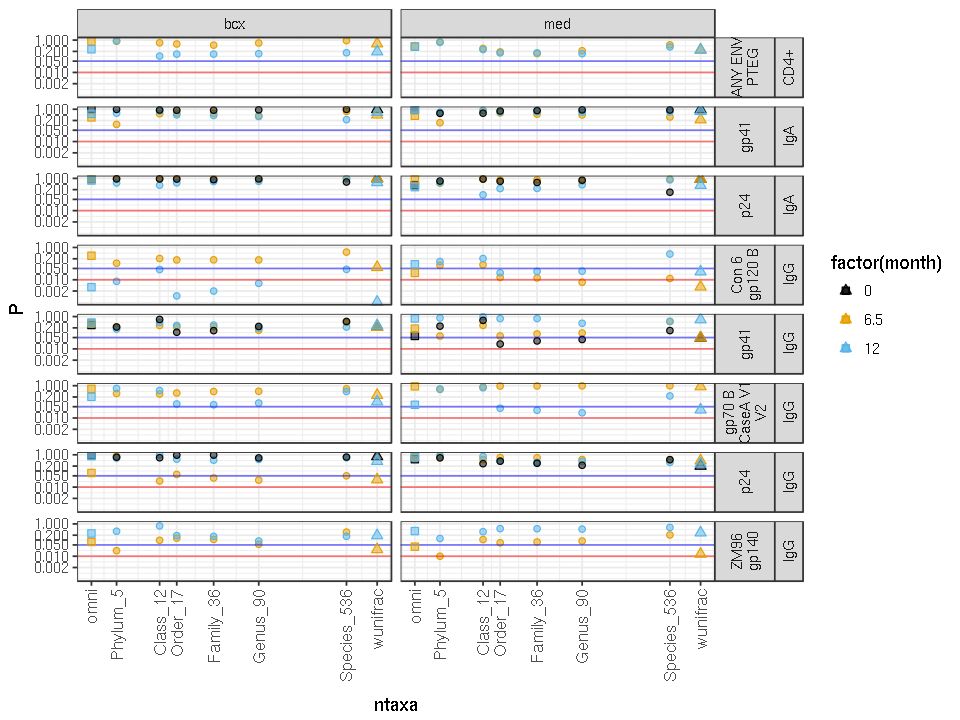

In [121]:
mirDat %>% 
#mutate(antigen = stringr::str_replace_all(antigen, "\\.", " ")) %>% 
fixstuff %>%
ggplot(aes(x = ntaxa, y = P, col = factor(month), fill = factor(month))) +
geom_point(pch = 21) +
facet_grid(type + antigen ~ metric, labeller = labeller(antigen = label_wrap_gen(width = 10))) + 
scale_x_log10(breaks = c(3, NTaxaAtLevel2$ntaxa, 1000), labels = c("omni", NTaxaAtLevel2$nLev, "wunifrac")) +
scale_y_log10(breaks = c(0.002, 0.01, 0.05, 0.2, 1)) + 
geom_hline(yintercept=0.05, col = 'blue', alpha = 0.5) + geom_hline(yintercept=0.01, col = 'red', alpha = 0.5) +
#geom_hline(data = mirOmni, aes(yintercept = P, col = factor(month))) +
#annotation_logticks(sides = 'bl') +
#geom_rug(data = mirOmni, aes(y = P, col = factor(month)), inherit.aes = F) +
geom_point(data = mirOmni %>% ungroup %>% fixstuff,
           aes(x = 3, y = P, col = factor(month), fill = factor(month)), inherit.aes = F, pch = 22, size = 2) +
geom_point(data = WufPData %>% ungroup %>% fixant,
           aes(x = 1000, y = mir.P, col = factor(month), fill = factor(month)), inherit.aes = F, pch = 24, size = 2) +

scale_colour_manual(values=cbPalette) + 
scale_fill_manual(values=alpha(cbPalette, 0.5)) + 
theme_bw() +
theme(axis.text.x = element_text(angle = 90, hjust = 1,, vjust = 0.5, size = 10),
     strip.text.y = (element_text(angle = 90))) -> pjsd0

options(repr.plot.width=8, repr.plot.height= 6)
pjsd0
options(par0)
# I'd like to add weighted unifrac as a tick mark on the right.

In [122]:
NTaxaAtLevel2

nLev,taxLevels,ntaxa
Phylum_5,Phylum,5
Class_12,Class,12
Order_17,Order,17
Family_36,Family,36
Genus_90,Genus,90
Species_536,Species,536


In [123]:
# New combined data frame that has omnibus, regular, and wunifrac all in one
bind_rows(
     mirDat %>% mutate(metric =  stringr::str_replace_all(metric, "JSD", "")) %>%
    mutate(test = "JSD"),
     mirOmni %>% ungroup %>% mutate(metric =  stringr::str_replace_all(metric, "JSD", "")) %>%
    mutate(taxLevels = "Omnibus") %>% mutate(test = "Omnibus"),
     WufPData %>% ungroup %>% dplyr::rename(P = mir.P) %>%
    mutate(taxLevels = "WUnifrac") %>% mutate(test = "WUnifrac")
) %>% 
mutate(antigen = factor(antigen, levels = c(ants2, ants1, "ANY.ENV.PTEG"))) %>%
mutate(type = factor(type, levels = c("IgA", "IgG", "CD4+"))) %>%
mutate(taxLevels = factor(taxLevels, levels = c("Omnibus", NTaxaAtLevel2$taxLevels, "WUnifrac"))) %>%
dplyr::select(-c(bcxJSDOmni:medJSDOmni))%>%
unite(nLev, taxLevels, ntaxa, remove = FALSE) %>%
mutate(nLev = stringr::str_replace(nLev, "_NA", "")) %>%
#mutate(antigen = stringr::str_replace_all(antigen, "\\.", " ")) %>%
#mutate(antigen = stringr::str_replace_all(antigen, "_", " ")) %>%
 mutate(antigen = factor(antigen, labels = stringr::str_replace_all(levels(antigen), "\\.", " "))) %>%
 mutate(antigen = factor(antigen, labels = stringr::str_replace_all(levels(antigen), "_", " "))) %>%


# mutate(antigen = factor(antigen, labels = (levels(antigen)))) %>%
# mutate(antigen = factor(antigen, labels = (levels(antigen)))) %>%

mutate(test = factor(test, levels = c('Omnibus', 'JSD', 'WUnifrac'))) %>%
pass -> mirDat2
mirDat2 %>% filter(type == 'CD4+')

Warning message in bind_rows_(x, .id):
“binding factor and character vector, coercing into character vector”Warning message in bind_rows_(x, .id):
“binding character and factor vector, coercing into character vector”

type,antigen,month,nLev,taxLevels,ntaxa,metric,P,test
CD4+,ANY ENV PTEG,6.5,Phylum_5,Phylum,5,bcx,0.84900,JSD
CD4+,ANY ENV PTEG,6.5,Class_12,Class,12,bcx,0.68700,JSD
CD4+,ANY ENV PTEG,6.5,Order_17,Order,17,bcx,0.57800,JSD
CD4+,ANY ENV PTEG,6.5,Family_36,Family,36,bcx,0.48900,JSD
CD4+,ANY ENV PTEG,6.5,Genus_90,Genus,90,bcx,0.66100,JSD
CD4+,ANY ENV PTEG,6.5,Species_536,Species,536,bcx,0.93300,JSD
CD4+,ANY ENV PTEG,12.0,Phylum_5,Phylum,5,bcx,0.92600,JSD
CD4+,ANY ENV PTEG,12.0,Class_12,Class,12,bcx,0.10300,JSD
CD4+,ANY ENV PTEG,12.0,Order_17,Order,17,bcx,0.13600,JSD
CD4+,ANY ENV PTEG,12.0,Family_36,Family,36,bcx,0.13600,JSD


In [124]:
mirDat2 %>% head

type,antigen,month,nLev,taxLevels,ntaxa,metric,P,test
IgA,gp41,6.5,Phylum_5,Phylum,5,bcx,0.115,JSD
IgA,gp41,6.5,Class_12,Class,12,bcx,0.525,JSD
IgA,gp41,6.5,Order_17,Order,17,bcx,0.575,JSD
IgA,gp41,6.5,Family_36,Family,36,bcx,0.555,JSD
IgA,gp41,6.5,Genus_90,Genus,90,bcx,0.401,JSD
IgA,gp41,6.5,Species_536,Species,536,bcx,0.730,JSD


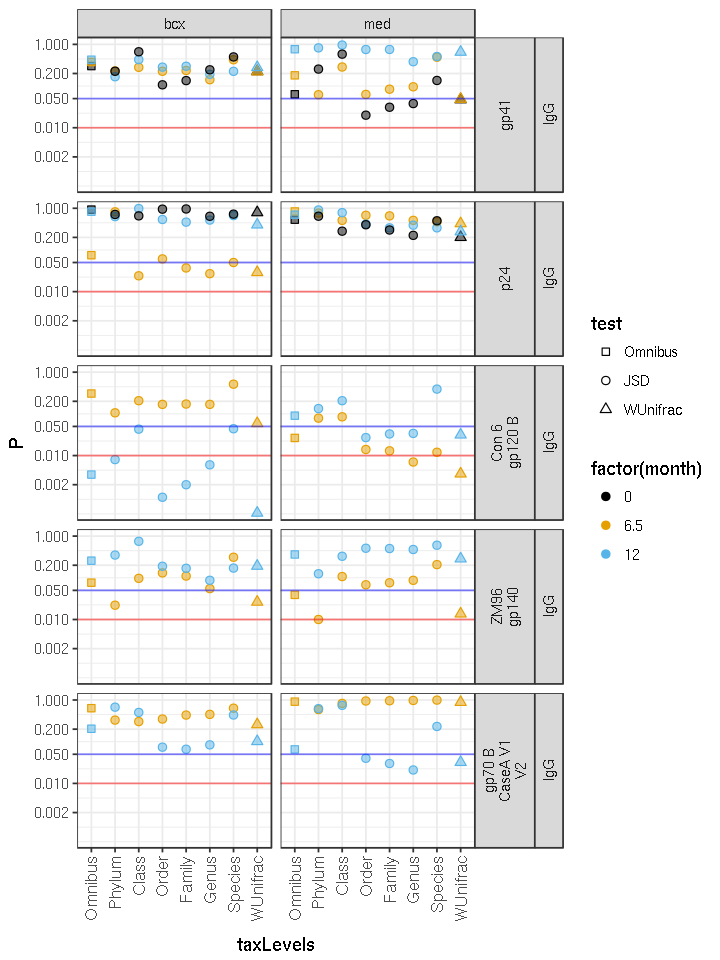

In [125]:
mirDat2 %>%
filter(type == "IgG") %>%
ggplot(aes(x = taxLevels, y = P, col = factor(month), fill = factor(month), shape = test)) +
geom_point(size = 2) +
facet_grid(type + antigen ~ metric, labeller = labeller(antigen = label_wrap_gen(width = 10))) + 
#scale_x_log10(breaks = c(3, NTaxaAtLevel2$ntaxa, 1000), labels = c("omni", NTaxaAtLevel2$nLev, "wunifrac")) +
scale_y_log10(breaks = c(0.002, 0.01, 0.05, 0.2, 1)) + 
geom_hline(yintercept=0.05, col = 'blue', alpha = 0.5) + geom_hline(yintercept=0.01, col = 'red', alpha = 0.5) +

scale_shape_manual(values = c(22, 21, 24)) +
scale_colour_manual(values=cbPalette) + 
scale_fill_manual(values=alpha(cbPalette, 0.5)) + 
theme_bw() +
theme(axis.text.x = element_text(angle = 90, hjust = 1,, vjust = 0.5, size = 10),
     strip.text.y = (element_text(angle = 90))) -> pjsd


options(repr.plot.width=6, repr.plot.height= 8)
pjsd

ggsave('figures/KernelPVsLevel.png', width = 6, height = 8)
options(par0)

X-axis is now spaced evenly

Table SX. P values of kernel regression tests. Circles indicate jensen shannon values at different taxonomic resolutions. Squares are the omnibus p-value for that cohort of tests. Triangles indicate kernel regression p-values for the corresponding weighted unifrac test.

The blue and red lines indicate p values of 5% and 1% respectively.

Observations: The weighted unifrac test is sensitive. In cases where only one taxonic level hits, weighted unifrac often also falls at some statistically significant value. The omnibus p value is often higher than the weighted unifrac one.
Weighted unifrac seems like a good test for identifying patterns at any level that relate to an outcome. The jensen shannon informs us about which level the pattern is observed.

# Local Tests

## Family, genera and species vs wuf1
I might even be able to drill down to every level.

In [126]:
model_each_species <- function(ps, f, pthresh = 1, q = FALSE){
    # Start with the otu table
ps %>%
# reshape it so we have clr values for every taxon-sample pair
otu_table %>% as.data.frame %>% rownames_to_column("Sample") %>% gather(Taxon, clr, -Sample) %>%
    # bind that to the sample data
    # doing this here seems remarkably inefficient, but its not creating a bottleneck so I'll leave it.
left_join(
    ps %>%
    # the sample data need to have MDS1 and MDS2 appended to them
    phylo_join(
    psN2.pcoa %>% scores(display = "sites") %>% # hardcoded psN2.pcoa
        as.data.frame %>% 
        rownames_to_column %>% 
        dplyr::select('rowname', 'MDS1', 'MDS2'),
    by = 'rowname'
) %>%
    # back to binding to sample data
    sample_data %>% as('data.frame') %>% rownames_to_column("Sample"),
     by = 'Sample') %>%

group_by(Taxon) %>%  # group and nest for model run
nest %>%
mutate(Mod = map(data, f)) %>% # apply model over each species
mutate(Glance = map(Mod, glance), Tidy = map(Mod, tidy)) %>% # extract relevant data from model
# view model
dplyr::select(Taxon, Tidy) %>% unnest %>%
mutate(term = gsub('[\\( \\)]','', term)) %>% # remove parentheses from "(Intercept)"
gather(meas, val, estimate:p.value) %>% 
unite(meas, term, meas) %>% spread(meas, val) %>% arrange(clr_estimate) %>% 
dplyr::select(Taxon, Intercept_estimate, clr_estimate, clr_std.error, clr_p.value) %>%
    # add q value
    {if(q) mutate(., clr_q.value = p2q(clr_p.value)) else .} %>%
    
 filter(clr_p.value < pthresh) %>%

     #Join taxonomy information
     left_join(
     ps %>% tax_table %>% as.data.frame %>% as.tibble %>% dplyr::select(Kingdom:Genus, Species, tag) %>%
         mutate(tag = as.character(tag)), # mutate so tag is and taxon are both character class
     by = c("Taxon" = "tag")) %>%
pass
 }

In [127]:
model_each_species_for_antigen <- function(antigen, ps = psN2){
    ps %>%
    model_each_species(function(df){glm(medcode2(get(antigen)) ~ clr, data = df, family = 'binomial')}, q = TRUE, pthresh = 1)
}

In [128]:
ColsToRun <- c('IgG_Con.6.gp120.B_Month_6.5', 'IgG_Con.6.gp120.B_Month_12', 'IgG_gp41_Month_0', 'IgG_gp41_Month_6.5', 'IgG_gp70_B.CaseA_V1_V2_Month_12', 'IgG_ZM96.gp140_Month_6.5', 'MDS1', 'isMale' ) 



In [129]:
model_each_species_case <- function(ps){
    
    ps %>% model_each_species(function(df){glm(MDS1 ~ clr, data = df, family = 'gaussian')}, q = TRUE, pthresh = 1) %>%
arrange(clr_estimate) %>%
mutate(Taxon = factor(Taxon, levels = Taxon[order(clr_estimate)])) %>%
    mutate(test = 'gaussian', antigen = 'MDS1') %>%
pass -> loc_mds1Glms
    
        ps %>% model_each_species(function(df){glm(log10(IgG_Con.6.gp120.B_Month_12 + 100) ~ clr, data = df, family = 'gaussian')}, q = TRUE, pthresh = 1) %>%
arrange(clr_estimate) %>%
 mutate(Taxon = factor(Taxon, levels = levels(loc_mds1Glms$Taxon))) %>%
    mutate(test = 'gaussian', antigen = 'Con.6.gp120.B_Month_12') %>%
 pass -> loc_gp120Glms
    
      tibble(antigen = ColsToRun) %>% mutate(model = map(antigen, ~model_each_species_for_antigen(., ps = ps))) %>%
  unnest %>% mutate(Taxon = factor(Taxon, levels = levels(loc_mds1Glms$Taxon))) %>%
        mutate(test = 'binomial') %>%
    pass-> loc_logitCoefs
    

    #list(loc_mds1Glms, loc_gp120Glms, loc_logitCoefs)
     bind_rows(loc_mds1Glms, loc_gp120Glms, loc_logitCoefs) %>% dplyr::select(test, antigen, everything())
    
}

In [130]:
#psDf %>% mutate(ps2 = map(ps, ~swap.phyloseq.taxnames(tag_phyloseq(remove_tag_phyloseq(.))))) -> test

In [131]:
#psDf[[1,"clr"]] %>% tax_table

In [132]:
psDf[[1]]

[1] "Phylum"  "Class"   "Order"   "Family"  "Genus"   "Species"

In [133]:
psDf %>% print

# A tibble: 6 x 9
  taxLevels ntaxa psCount        ps      jsd    jsdMat   kjsd   psNoZero clr   
  <chr>     <int> <list>         <list>  <list> <list>   <list> <list>   <list>
1 Phylum        5 <S4: phyloseq> <S4: p… <S3: … <dbl [2… <dbl … <S4: ph… <S4: …
2 Class        12 <S4: phyloseq> <S4: p… <S3: … <dbl [2… <dbl … <S4: ph… <S4: …
3 Order        17 <S4: phyloseq> <S4: p… <S3: … <dbl [2… <dbl … <S4: ph… <S4: …
4 Family       36 <S4: phyloseq> <S4: p… <S3: … <dbl [2… <dbl … <S4: ph… <S4: …
5 Genus        90 <S4: phyloseq> <S4: p… <S3: … <dbl [2… <dbl … <S4: ph… <S4: …
6 Species     536 <S4: phyloseq> <S4: p… <S3: … <dbl [2… <dbl … <S4: ph… <S4: …


In [134]:
ptm = proc.time()
psDf %>% dplyr::select(taxLevels, ntaxa, clr) %>% mutate(localmod = map(clr, model_each_species_case)) ->psDfLoc
proc.time() - ptm

Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”

   user  system elapsed 
 83.786   0.368  84.216 

In [135]:
print(psDfLoc)

# A tibble: 6 x 4
  taxLevels ntaxa clr            localmod             
  <chr>     <int> <list>         <list>               
1 Phylum        5 <S4: phyloseq> <tibble [50 × 15]>   
2 Class        12 <S4: phyloseq> <tibble [120 × 15]>  
3 Order        17 <S4: phyloseq> <tibble [170 × 15]>  
4 Family       36 <S4: phyloseq> <tibble [360 × 15]>  
5 Genus        90 <S4: phyloseq> <tibble [900 × 15]>  
6 Species     536 <S4: phyloseq> <tibble [5,360 × 15]>


In [136]:
psDfLoc %>% dplyr::select(-clr) %>% unnest(localmod) -> tmp

Warning message in bind_rows_(x, .id):
“Unequal factor levels: coercing to character”Warning message in bind_rows_(x, .id):
“binding character and factor vector, coercing into character vector”Warning message in bind_rows_(x, .id):
“binding character and factor vector, coercing into character vector”Warning message in bind_rows_(x, .id):
“Unequal factor levels: coercing to character”Warning message in bind_rows_(x, .id):
“binding character and factor vector, coercing into character vector”Warning message in bind_rows_(x, .id):
“binding character and factor vector, coercing into character vector”Warning message in bind_rows_(x, .id):
“Unequal factor levels: coercing to character”Warning message in bind_rows_(x, .id):
“binding character and factor vector, coercing into character vector”Warning message in bind_rows_(x, .id):
“binding character and factor vector, coercing into character vector”Warning message in bind_rows_(x, .id):
“Unequal factor levels: coercing to character”Warning mess

In [137]:
psDfLoc$taxLevels

[1] "Phylum"  "Class"   "Order"   "Family"  "Genus"   "Species"

In [138]:
tmp %>% mutate(taxLevels = factor(taxLevels, levels = psDfLoc$taxLevels)) -> LocalTests

## I want to show the local tests vs antibodies.

In [139]:
LocalTests %>% head

taxLevels,ntaxa,test,antigen,Taxon,Intercept_estimate,clr_estimate,clr_std.error,clr_p.value,clr_q.value,Kingdom,Phylum,Class,Order,Family,Genus,Species
Phylum,5,gaussian,MDS1,Bacteroidetes,1.9797921,-0.7778703,0.2372915,0.003955489,0.007607443,Bacteria,Bacteroidetes,NA,NA,NA,NA,NA
Phylum,5,gaussian,MDS1,Porphyromonadaceae,-1.0229577,-0.5032637,0.1880937,0.014955140,0.014381330,Bacteria,Bacteroidetes,Bacteroidia,Bacteroidales,Porphyromonadaceae,NA,NA
Phylum,5,gaussian,MDS1,Actinobacteria,-0.2679471,-0.1391228,0.2077476,0.511123802,0.196605046,Bacteria,Actinobacteria,Actinobacteria,NA,NA,NA,NA
Phylum,5,gaussian,MDS1,Campylobacter,0.4456659,0.2474623,0.1058586,0.030497772,0.019551740,Bacteria,Proteobacteria,Epsilonproteobacteria,Campylobacterales,Campylobacteraceae,Campylobacter,NA
Phylum,5,gaussian,MDS1,Bacteria,-1.2850969,0.3997908,0.2629518,0.144878955,0.069660064,Bacteria,NA,NA,NA,NA,NA,NA
Phylum,5,gaussian,Con.6.gp120.B_Month_12,Bacteria,3.7823748,-0.2922472,0.1706909,0.103144366,0.171907277,Bacteria,NA,NA,NA,NA,NA,NA


Saving 6.67 x 6.67 in image


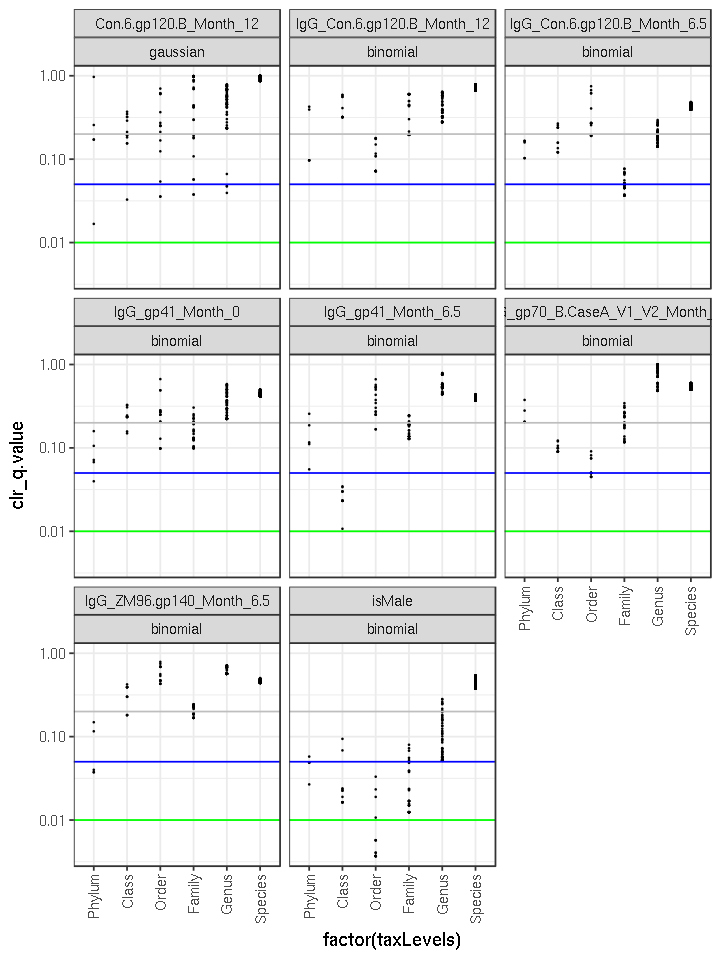

In [140]:
options(repr.plot.width=6, repr.plot.height=8)
LocalTests %>% 
filter(antigen != "MDS1") %>%
ggplot(aes(x = factor(taxLevels), y = clr_q.value)) + geom_point(size = 0.1) +
geom_hline(yintercept = 0.2, color = 'grey') +
 geom_hline(yintercept = 0.05, color = 'blue') + geom_hline(yintercept = 0.01, color = 'green') +
facet_wrap(~antigen + test) + scale_y_log10() +
theme_bw() +
theme(axis.text.x = element_text(angle = 90, hjust = 1, vjust = 0.5))

ggsave('figures/LocalQEveryLevel.png')

Saving 6.67 x 6.67 in image


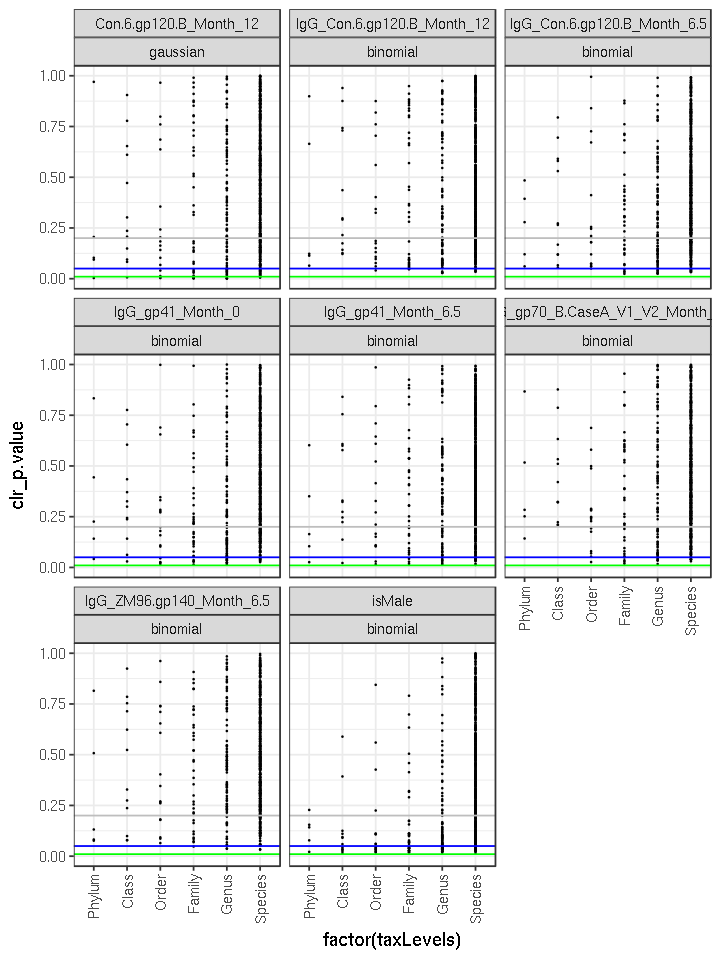

In [141]:
options(repr.plot.width=6, repr.plot.height=8)
LocalTests %>% 
filter(antigen != "MDS1") %>%
ggplot(aes(x = factor(taxLevels), y = clr_p.value)) + geom_point(size = 0.1) +
geom_hline(yintercept = 0.2, color = 'grey') +
 geom_hline(yintercept = 0.05, color = 'blue') + geom_hline(yintercept = 0.01, color = 'green') +
facet_wrap(~antigen + test) +# scale_y_log10() +
theme_bw() +
theme(axis.text.x = element_text(angle = 90, hjust = 1, vjust = 0.5))
ggsave('figures/LocalPEveryLevel.png')

Saving 6.67 x 6.67 in image


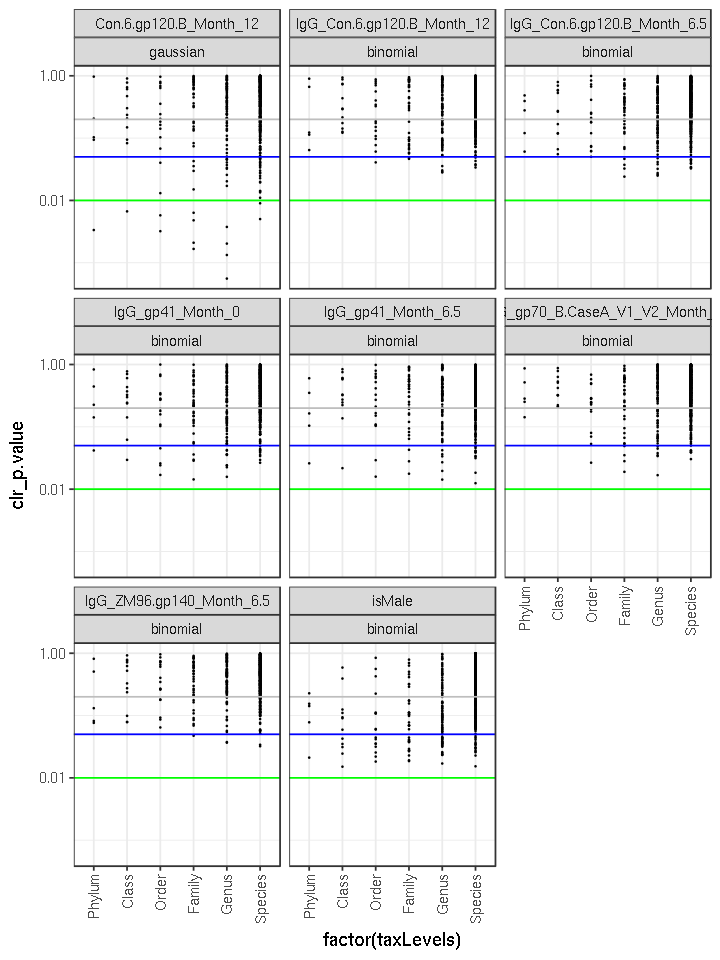

In [142]:
options(repr.plot.width=6, repr.plot.height=8)
LocalTests %>% 
filter(antigen != "MDS1") %>%
ggplot(aes(x = factor(taxLevels), y = clr_p.value)) + geom_point(size = 0.1) +
geom_hline(yintercept = 0.2, color = 'grey') +
 geom_hline(yintercept = 0.05, color = 'blue') + geom_hline(yintercept = 0.01, color = 'green') +
facet_wrap(~antigen + test) + scale_y_log10() +
theme_bw() +
theme(axis.text.x = element_text(angle = 90, hjust = 1, vjust = 0.5))
ggsave('figures/LocalPEveryLevel_LogScale.png')

In [143]:
order_taxa_by_mds1 <- function(df){
    # this has to be a model_each_species type of data frame
    df %>% filter(antigen == 'MDS1' & test == 'gaussian') %>%
    mutate(TaxonF = factor(Taxon, levels = Taxon[order(clr_estimate)])) -> mds1df
    df %>% mutate(TaxonF = factor(Taxon, levels = levels(mds1df$TaxonF)))
}

To my annoyance, everything is labeled with IgG except gp120_12

In [144]:
LocalTests %>%
filter(taxLevels == 'Family') %>%
order_taxa_by_mds1 %>%

filter(
    (antigen %in% c('IgG_gp41_Month_0', 'IgG_gp41_Month_6.5', 'IgG_Con.6.gp120.B_Month_6.5'))|
    (antigen == 'Con.6.gp120.B_Month_12' & test == 'gaussian')
      ) %>%
mutate(antigen = factor(antigen,
                        levels = c('IgG_gp41_Month_0', 'IgG_gp41_Month_6.5',
                                   'IgG_Con.6.gp120.B_Month_6.5', 'Con.6.gp120.B_Month_12'))) %>%
filter(clr_p.value < 0.05 & clr_q.value < 0.2) %>%
dplyr::select(antigen:clr_estimate) %>%
dplyr::select(-Intercept_estimate) %>%
mutate(cordir = sign(clr_estimate)) %>%
pass

antigen,Taxon,clr_estimate,cordir
Con.6.gp120.B_Month_12,Bacteroidetes.2,-0.3052386,-1
Con.6.gp120.B_Month_12,Firmicutes.2,-0.2921091,-1
Con.6.gp120.B_Month_12,Fusobacterium,-0.1817774,-1
Con.6.gp120.B_Month_12,Bacilli,-0.1585977,-1
Con.6.gp120.B_Month_12,Clostridia,-0.1464105,-1
Con.6.gp120.B_Month_12,Firmicutes.3,0.2002285,1
Con.6.gp120.B_Month_12,Bacteroides,0.2125381,1
Con.6.gp120.B_Month_12,Porphyromonadaceae.1,0.2518832,1
IgG_Con.6.gp120.B_Month_6.5,Firmicutes.2,-1.7703200,-1
IgG_Con.6.gp120.B_Month_6.5,Bacteroides,1.0970012,1


In [145]:
LocalTests %>% pull(antigen) %>% unique

[1] "MDS1"                            "Con.6.gp120.B_Month_12"         
[3] "IgG_Con.6.gp120.B_Month_6.5"     "IgG_Con.6.gp120.B_Month_12"     
[5] "IgG_gp41_Month_0"                "IgG_gp41_Month_6.5"             
[7] "IgG_gp70_B.CaseA_V1_V2_Month_12" "IgG_ZM96.gp140_Month_6.5"       
[9] "isMale"

[1] Con.6.gp120.B_Month_12          IgG_Con.6.gp120.B_Month_6.5    
[3] IgG_gp41_Month_0                IgG_gp41_Month_6.5             
[5] IgG_gp70_B.CaseA_V1_V2_Month_12 IgG_ZM96.gp140_Month_6.5       
6 Levels: IgG_gp41_Month_0 IgG_gp41_Month_6.5 ... IgG_gp70_B.CaseA_V1_V2_Month_12

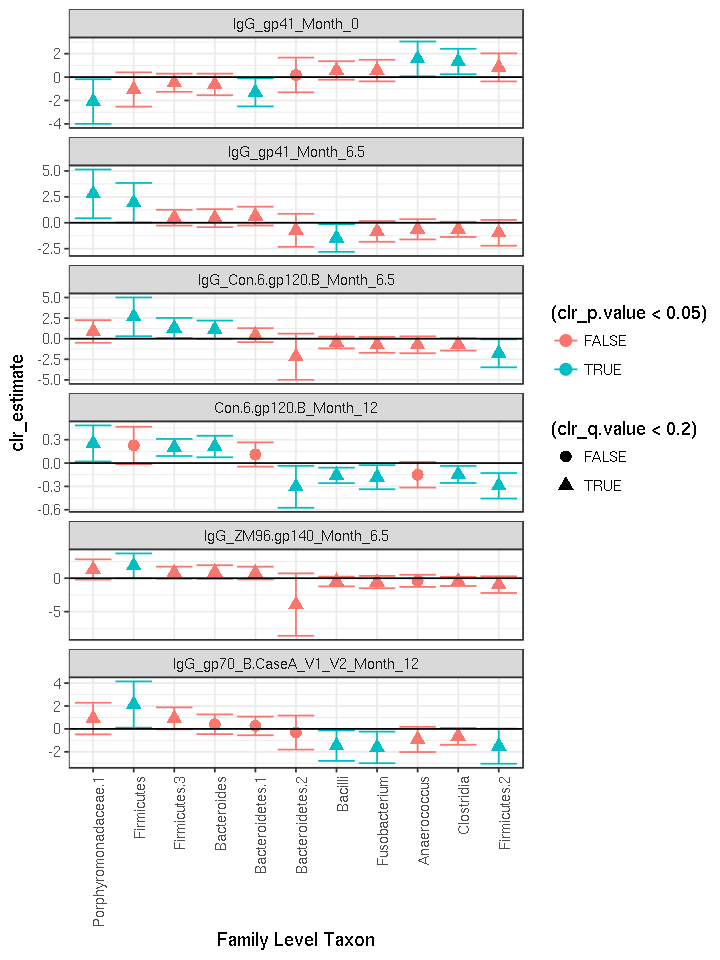

In [146]:
# Family Hits
LocalTests %>%
filter(taxLevels == 'Family') %>%
order_taxa_by_mds1 %>%

filter(
    (antigen %in% c('IgG_gp41_Month_0', 'IgG_gp41_Month_6.5', 'IgG_Con.6.gp120.B_Month_6.5', 
                    'IgG_ZM96.gp140_Month_6.5','IgG_gp70_B.CaseA_V1_V2_Month_12'))|
    (antigen == 'Con.6.gp120.B_Month_12' & test == 'gaussian')
      ) %>%
mutate(antigen = factor(antigen, levels = c(
    'IgG_gp41_Month_0', 'IgG_gp41_Month_6.5', 'IgG_Con.6.gp120.B_Month_6.5', 'Con.6.gp120.B_Month_12',
    'IgG_ZM96.gp140_Month_6.5','IgG_gp70_B.CaseA_V1_V2_Month_12'
))) %>%
pass -> tmp

tmp$antigen %>% unique

tmp %>% filter(clr_p.value < 0.05 & clr_q.value < 0.2) %>%
pull(Taxon) %>% unique -> useFamily

tmp %>% filter(Taxon %in% useFamily) %>%

ggplot(aes(x = TaxonF, y = clr_estimate,
           color = (clr_p.value < 0.05), shape =(clr_q.value < 0.2))) +
geom_point(size = 3) + 
geom_errorbar(aes(ymin = clr_estimate - 2*clr_std.error, ymax = clr_estimate + 2*clr_std.error)) + 
theme_bw() +
theme(axis.text.x = element_text(angle = 90, hjust = 1)) + geom_hline(yintercept = 0) +
facet_wrap(~antigen, ncol = 1, scales = 'free_y') + xlab("Family Level Taxon")
# Show the censored ones accross - so this would be everything with at least one hit
# but also show what they are in all cases.

ggsave('figures/anyFamilyIgg.png', width = 6, height = 8)

I think its worth digging into clostridia and Prophyromonidaceae with stacked bars

# Proportionality heatmap

Family level

Lets come back to this after we've done the local tests. Since we need them to color code the axes.

In [147]:
psDf %>% print

# A tibble: 6 x 9
  taxLevels ntaxa psCount        ps      jsd    jsdMat   kjsd   psNoZero clr   
  <chr>     <int> <list>         <list>  <list> <list>   <list> <list>   <list>
1 Phylum        5 <S4: phyloseq> <S4: p… <S3: … <dbl [2… <dbl … <S4: ph… <S4: …
2 Class        12 <S4: phyloseq> <S4: p… <S3: … <dbl [2… <dbl … <S4: ph… <S4: …
3 Order        17 <S4: phyloseq> <S4: p… <S3: … <dbl [2… <dbl … <S4: ph… <S4: …
4 Family       36 <S4: phyloseq> <S4: p… <S3: … <dbl [2… <dbl … <S4: ph… <S4: …
5 Genus        90 <S4: phyloseq> <S4: p… <S3: … <dbl [2… <dbl … <S4: ph… <S4: …
6 Species     536 <S4: phyloseq> <S4: p… <S3: … <dbl [2… <dbl … <S4: ph… <S4: …


In [148]:
psDf %>% filter(taxLevels == 'Family') %>% dplyr::select(ps) %>% pull %>%.[[1]]

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 36 taxa and 21 samples ]
sample_data() Sample Data:       [ 21 samples by 35 sample variables ]
tax_table()   Taxonomy Table:    [ 36 taxa by 12 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 36 tips and 35 internal nodes ]

In [149]:
print(psDf)

# A tibble: 6 x 9
  taxLevels ntaxa psCount        ps      jsd    jsdMat   kjsd   psNoZero clr   
  <chr>     <int> <list>         <list>  <list> <list>   <list> <list>   <list>
1 Phylum        5 <S4: phyloseq> <S4: p… <S3: … <dbl [2… <dbl … <S4: ph… <S4: …
2 Class        12 <S4: phyloseq> <S4: p… <S3: … <dbl [2… <dbl … <S4: ph… <S4: …
3 Order        17 <S4: phyloseq> <S4: p… <S3: … <dbl [2… <dbl … <S4: ph… <S4: …
4 Family       36 <S4: phyloseq> <S4: p… <S3: … <dbl [2… <dbl … <S4: ph… <S4: …
5 Genus        90 <S4: phyloseq> <S4: p… <S3: … <dbl [2… <dbl … <S4: ph… <S4: …
6 Species     536 <S4: phyloseq> <S4: p… <S3: … <dbl [2… <dbl … <S4: ph… <S4: …


In [150]:
#nFamilyTaxa <- NTaxaAtLevel %>% filter(taxLevels == 'Family') %>% pull(ntaxa)

psDf %>% filter(taxLevels == 'Family') %>% dplyr::select(psNoZero) %>% pull %>%.[[1]] %>%
otu_table %>% as.data.frame %>%
pass -> myRel

ptm = proc.time()
phiBoot <- boot(data = myRel, statistic = boot_phi, R = 1000)
proc.time() - ptm

ptm = proc.time()
tidyCI <- unwarn(
    tidy(phiBoot,conf.int=TRUE,conf.method="bca")
    )
proc.time() - ptm

myRel %>% make_proportionality_matrix %>% 
         as.data.frame %>%
         rownames_to_column("TaxonX") %>% gather(TaxonY, phi, -TaxonX) %>%
    filter(TaxonX != TaxonY) %>% data.frame(tidyCI) -> namedTidyCI

   user  system elapsed 
 17.720   0.092  17.828 

   user  system elapsed 
 24.140   0.248  24.406 

In [151]:
head(LocalTests)

taxLevels,ntaxa,test,antigen,Taxon,Intercept_estimate,clr_estimate,clr_std.error,clr_p.value,clr_q.value,Kingdom,Phylum,Class,Order,Family,Genus,Species
Phylum,5,gaussian,MDS1,Bacteroidetes,1.9797921,-0.7778703,0.2372915,0.003955489,0.007607443,Bacteria,Bacteroidetes,NA,NA,NA,NA,NA
Phylum,5,gaussian,MDS1,Porphyromonadaceae,-1.0229577,-0.5032637,0.1880937,0.014955140,0.014381330,Bacteria,Bacteroidetes,Bacteroidia,Bacteroidales,Porphyromonadaceae,NA,NA
Phylum,5,gaussian,MDS1,Actinobacteria,-0.2679471,-0.1391228,0.2077476,0.511123802,0.196605046,Bacteria,Actinobacteria,Actinobacteria,NA,NA,NA,NA
Phylum,5,gaussian,MDS1,Campylobacter,0.4456659,0.2474623,0.1058586,0.030497772,0.019551740,Bacteria,Proteobacteria,Epsilonproteobacteria,Campylobacterales,Campylobacteraceae,Campylobacter,NA
Phylum,5,gaussian,MDS1,Bacteria,-1.2850969,0.3997908,0.2629518,0.144878955,0.069660064,Bacteria,NA,NA,NA,NA,NA,NA
Phylum,5,gaussian,Con.6.gp120.B_Month_12,Bacteria,3.7823748,-0.2922472,0.1706909,0.103144366,0.171907277,Bacteria,NA,NA,NA,NA,NA,NA


In [152]:
LocalTests %>% filter(test == 'gaussian' &
                        antigen == 'MDS1' &
                         clr_p.value <0.05 &
                        clr_q.value < 0.2&
                        taxLevels == "Family") -> tmp
tmp %>% pull(Taxon) -> MDS1Fam
tmp %>% filter(clr_estimate < 0) %>% pull(Taxon) -> lowMDS1Fam
tmp %>% filter(clr_estimate >= 0) %>% pull(Taxon) -> highMDS1Fam

https://stackoverflow.com/questions/48531987/incorporate-more-information-about-variables-on-axes-into-a-heatmap-in-ggplot/48532983#48532983

I'd like to do this, but for gp41 baseline and gp120 as well.

In [153]:
useFamily

[1] "Bacteroidetes.2"      "Firmicutes.2"         "Fusobacterium"       
 [4] "Bacilli"              "Clostridia"           "Firmicutes.3"        
 [7] "Bacteroides"          "Porphyromonadaceae.1" "Firmicutes"          
[10] "Bacteroidetes.1"      "Anaerococcus"

In [154]:
LocalTests %>% head

taxLevels,ntaxa,test,antigen,Taxon,Intercept_estimate,clr_estimate,clr_std.error,clr_p.value,clr_q.value,Kingdom,Phylum,Class,Order,Family,Genus,Species
Phylum,5,gaussian,MDS1,Bacteroidetes,1.9797921,-0.7778703,0.2372915,0.003955489,0.007607443,Bacteria,Bacteroidetes,NA,NA,NA,NA,NA
Phylum,5,gaussian,MDS1,Porphyromonadaceae,-1.0229577,-0.5032637,0.1880937,0.014955140,0.014381330,Bacteria,Bacteroidetes,Bacteroidia,Bacteroidales,Porphyromonadaceae,NA,NA
Phylum,5,gaussian,MDS1,Actinobacteria,-0.2679471,-0.1391228,0.2077476,0.511123802,0.196605046,Bacteria,Actinobacteria,Actinobacteria,NA,NA,NA,NA
Phylum,5,gaussian,MDS1,Campylobacter,0.4456659,0.2474623,0.1058586,0.030497772,0.019551740,Bacteria,Proteobacteria,Epsilonproteobacteria,Campylobacterales,Campylobacteraceae,Campylobacter,NA
Phylum,5,gaussian,MDS1,Bacteria,-1.2850969,0.3997908,0.2629518,0.144878955,0.069660064,Bacteria,NA,NA,NA,NA,NA,NA
Phylum,5,gaussian,Con.6.gp120.B_Month_12,Bacteria,3.7823748,-0.2922472,0.1706909,0.103144366,0.171907277,Bacteria,NA,NA,NA,NA,NA,NA


In [155]:
reshape2::melt

function (data, ..., na.rm = FALSE, value.name = "value") 
{
    UseMethod("melt", data)
}
<environment: namespace:reshape2>

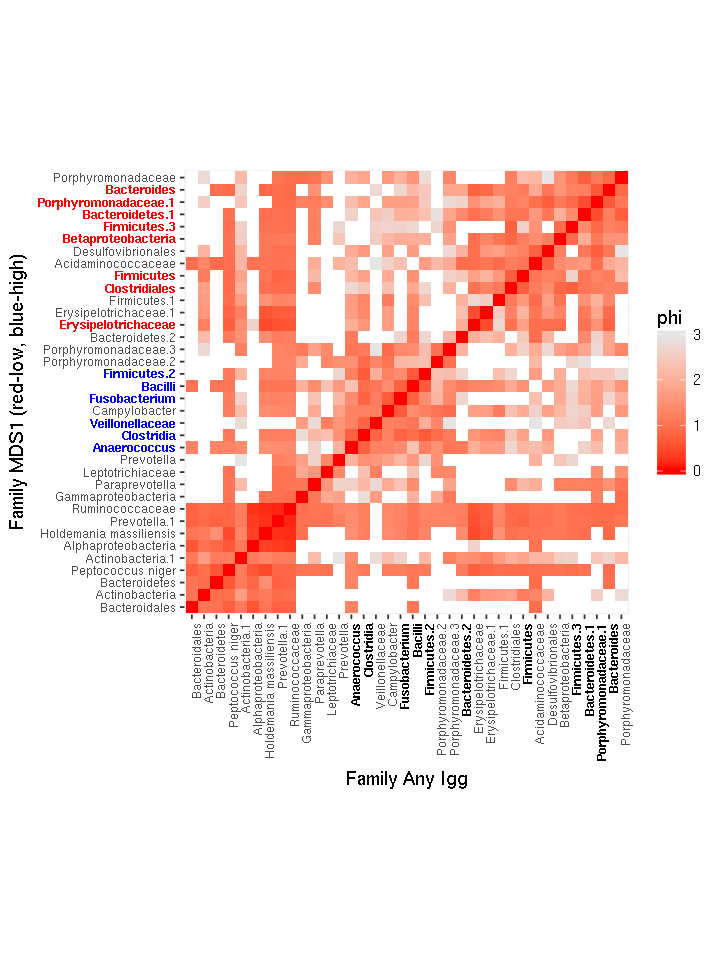

In [156]:
targStat <- "phi"
namedTidyCI %>% dplyr::select(TaxonX, TaxonY, targStat) %>% spread(key = TaxonY, value = targStat) %>%
remove_rownames %>% column_to_rownames("TaxonX") %>%
as.dist %>% as.matrix -> phidata

phi_dd <- as.dist(phidata)
phi_hc <- hclust(phi_dd)

phidata %>%
#.[phi_hc$order, phi_hc$order] %>% # this way also worked just fine
reshape2::melt() %>%
mutate(Var1 = factor(Var1, levels = unique(phi_hc$labels)[phi_hc$order])) %>%
mutate(Var2 = factor(Var2, levels = unique(phi_hc$labels)[phi_hc$order])) %>%
pass-> tmp

ggplot(tmp, aes(Var1, Var2, fill =(value))) + 
geom_tile() +
  scale_fill_gradient(high = "grey90", low = "red", 
    space = "Lab", 
    name="phi",
                    limits = c(NA, 3), na.value = "white") +
#  theme_minimal()+ # minimal theme
 theme(axis.text.x = element_text(
     angle = 90, vjust = 1, size = 7, hjust = 1,
     face = ifelse(levels(tmp$Var1) %in% useFamily, "bold", "plain"),
     colour = ifelse(levels(tmp$Var1) %in% useFamily, "black", "grey30")
                                 ),
       axis.text.y = element_text(
           size = 7,
           face = ifelse(levels(tmp$Var1) %in% MDS1Fam, "bold", "plain"),
           colour = ifelse(levels(tmp$Var1) %in% lowMDS1Fam, "red",
                          ifelse(levels(tmp$Var1) %in% highMDS1Fam, "blue", "grey30"))
       ))+
 coord_fixed() +
labs(x = "Family Any Igg",y = "Family MDS1 (red-low, blue-high)" )-> p_phi_1
p_phi_1
# ggsave("figures/phi_vs_mds1_and_igg.png", p_phi_1, width = 6, height = 6)

In [157]:
LocalTests %>%
filter(taxLevels == 'Family') %>%
order_taxa_by_mds1 %>%

filter(
    (antigen %in% c('IgG_gp41_Month_0', 'IgG_gp41_Month_6.5', 'IgG_Con.6.gp120.B_Month_6.5',
                   'IgG_ZM96.gp140_Month_6.5','IgG_gp70_B.CaseA_V1_V2_Month_12'))|
    (antigen == 'Con.6.gp120.B_Month_12' & test == 'gaussian')
      ) %>%
mutate(antigen = factor(antigen, levels = c('IgG_gp41_Month_0', 'IgG_gp41_Month_6.5', 'IgG_Con.6.gp120.B_Month_6.5', 'Con.6.gp120.B_Month_12',
                                           'IgG_ZM96.gp140_Month_6.5','IgG_gp70_B.CaseA_V1_V2_Month_12'))) %>%
pass -> tmp

tmp %>% dplyr::select(antigen, Taxon, clr_estimate, clr_p.value, clr_q.value) %>%
mutate(clr_sign = sign(clr_estimate)) %>%
mutate(isHit = ifelse(clr_p.value < 0.05 & clr_q.value < 0.2, 1, 0)) %>%
mutate(Taxon = factor(Taxon, levels = unique(phi_hc$labels)[phi_hc$order])) %>%
pass -> chorddata

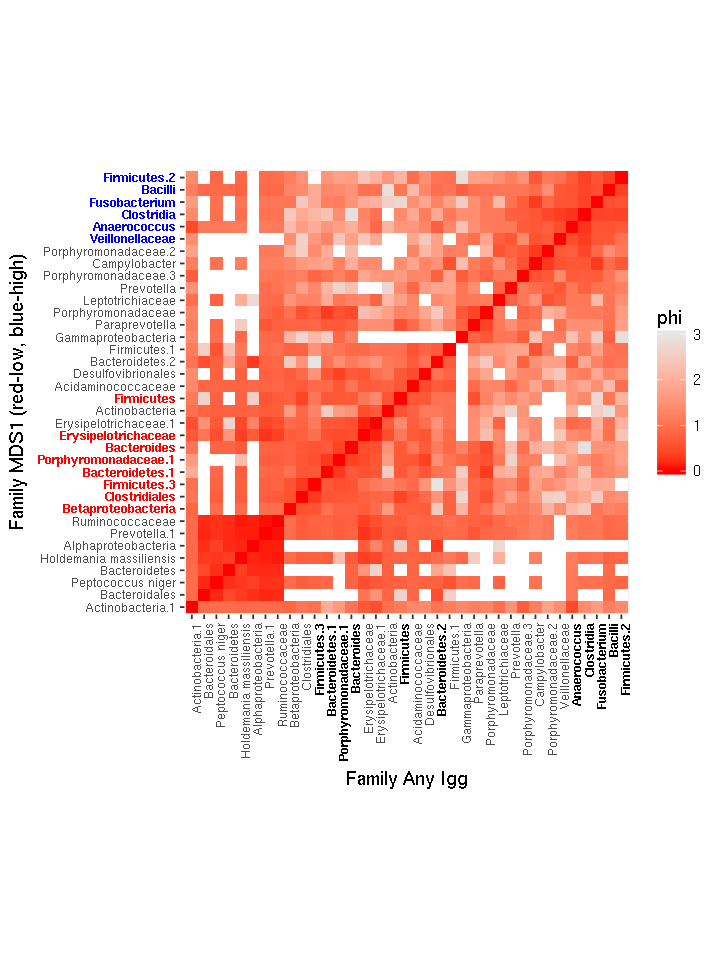

In [158]:
targStat <- "conf.low"
namedTidyCI %>% dplyr::select(TaxonX, TaxonY, targStat) %>% spread(key = TaxonY, value = targStat) %>%
remove_rownames %>% column_to_rownames("TaxonX") %>%
as.dist %>% as.matrix -> phidata

phi_dd <- as.dist(phidata)
phi_hc <- hclust(phi_dd)

phidata %>%
#.[phi_hc$order, phi_hc$order] %>% # this way also worked just fine
reshape2::melt() %>%
mutate(Var1 = factor(Var1, levels = unique(phi_hc$labels)[phi_hc$order])) %>%
mutate(Var2 = factor(Var2, levels = unique(phi_hc$labels)[phi_hc$order])) %>%
pass-> tmp

ggplot(tmp, aes(Var1, Var2, fill =(value))) + 
geom_tile() +
  scale_fill_gradient(high = "grey90", low = "red", 
    space = "Lab", 
    name="phi",
                    limits = c(NA, 3), na.value = "white") +
#  theme_minimal()+ # minimal theme
 theme(axis.text.x = element_text(
     angle = 90, vjust = 1, size = 7, hjust = 1,
     face = ifelse(levels(tmp$Var1) %in% useFamily, "bold", "plain"),
     colour = ifelse(levels(tmp$Var1) %in% useFamily, "black", "grey30")
                                 ),
       axis.text.y = element_text(
           size = 7,
           face = ifelse(levels(tmp$Var1) %in% MDS1Fam, "bold", "plain"),
           colour = ifelse(levels(tmp$Var1) %in% lowMDS1Fam, "red",
                          ifelse(levels(tmp$Var1) %in% highMDS1Fam, "blue", "grey30"))
       ))+
 coord_fixed() +
labs(x = "Family Any Igg",y = "Family MDS1 (red-low, blue-high)" )-> p_phi_low
p_phi_low

# ggsave("figures/phi_vs_mds1_and_igg.png", p_phi_1, width = 6, height = 6)

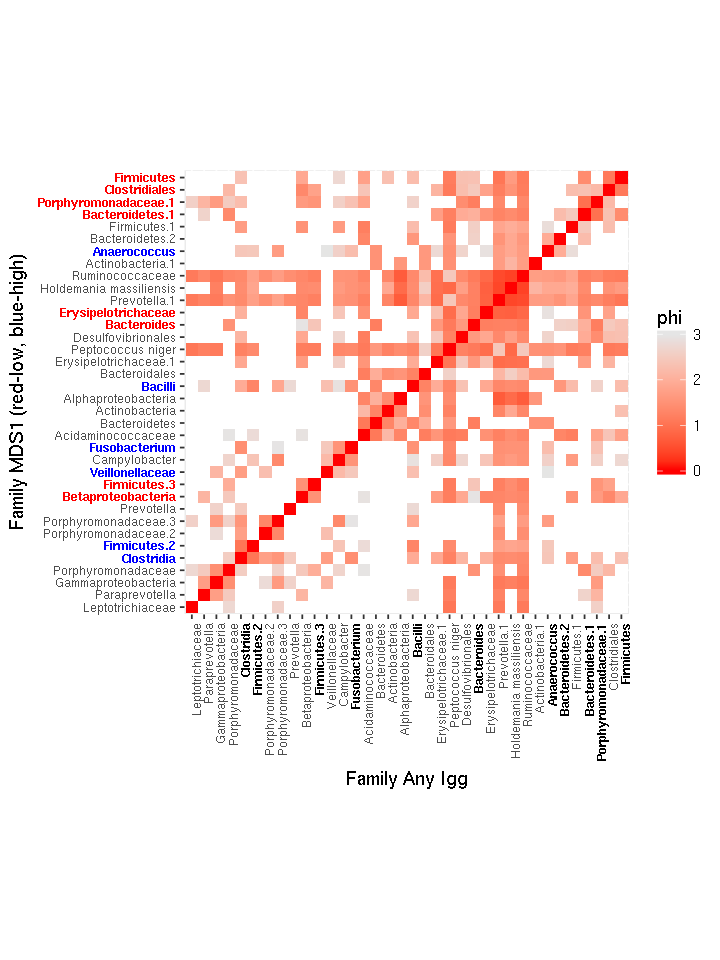

In [159]:
targStat <- "conf.high"
namedTidyCI %>% dplyr::select(TaxonX, TaxonY, targStat) %>% spread(key = TaxonY, value = targStat) %>%
remove_rownames %>% column_to_rownames("TaxonX") %>%
as.dist %>% as.matrix -> phidata

phi_dd <- as.dist(phidata)
phi_hc <- hclust(phi_dd)

phidata %>%
#.[phi_hc$order, phi_hc$order] %>% # this way also worked just fine
reshape2::melt() %>%
mutate(Var1 = factor(Var1, levels = unique(phi_hc$labels)[phi_hc$order])) %>%
mutate(Var2 = factor(Var2, levels = unique(phi_hc$labels)[phi_hc$order])) %>%
pass-> tmp

ggplot(tmp, aes(Var1, Var2, fill =(value))) + 
geom_tile() +
  scale_fill_gradient(high = "grey90", low = "red", 
    space = "Lab", 
    name="phi",
                    limits = c(NA, 3), na.value = "white") +
#  theme_minimal()+ # minimal theme
 theme(axis.text.x = element_text(
     angle = 90, vjust = 1, size = 7, hjust = 1,
     face = ifelse(levels(tmp$Var1) %in% useFamily, "bold", "plain"),
     colour = ifelse(levels(tmp$Var1) %in% useFamily, "black", "grey30")
                                 ),
       axis.text.y = element_text(
           size = 7,
           face = ifelse(levels(tmp$Var1) %in% MDS1Fam, "bold", "plain"),
           colour = ifelse(levels(tmp$Var1) %in% lowMDS1Fam, "red",
                          ifelse(levels(tmp$Var1) %in% highMDS1Fam, "blue", "grey30"))
       ))+
 coord_fixed() +
labs(x = "Family Any Igg",y = "Family MDS1 (red-low, blue-high)" )-> p_phi_high
p_phi_high
# ggsave("figures/phi_vs_mds1_and_igg.png", p_phi_1, width = 6, height = 6)

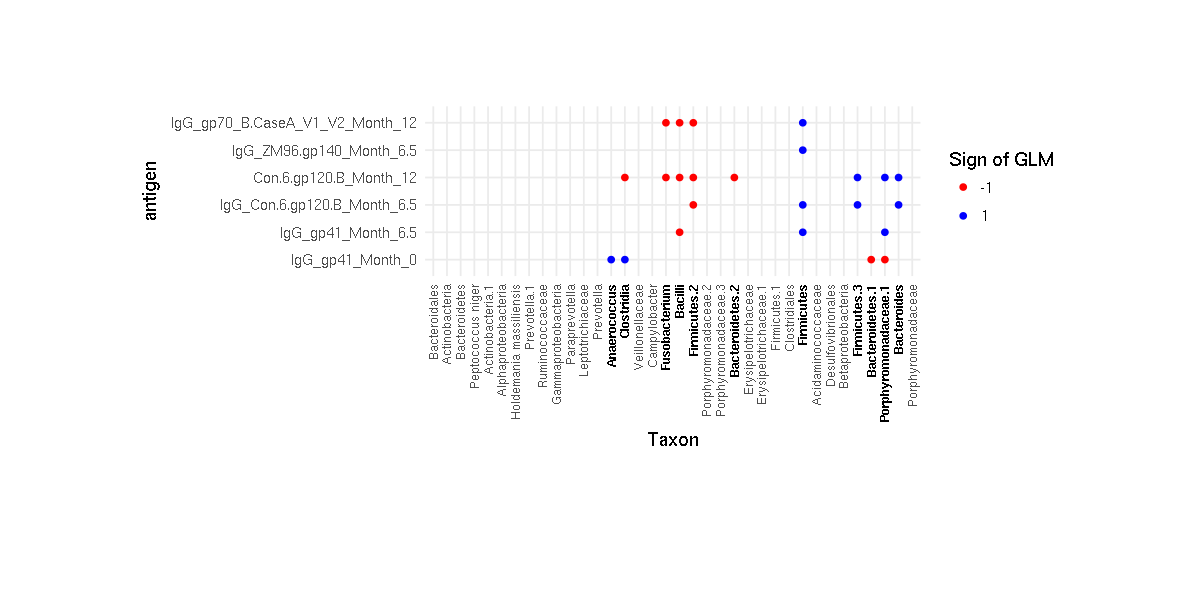

In [160]:
ggplot(chorddata,
    aes(x = Taxon, y = antigen, alpha = factor(isHit), color = factor(clr_sign))) +
scale_alpha_discrete(range = c(0, 1)) +
guides(alpha = FALSE) +
theme_minimal() +
     coord_fixed(ratio = 2) +
scale_colour_manual(values = c("red", "blue")) +
 theme(axis.text.x = element_text(
     angle = 90, vjust = 0.5, size = 7, hjust = 1,
     face = ifelse(levels(chorddata$Taxon) %in% useFamily, "bold", "plain"),
     colour = ifelse(levels(chorddata$Taxon) %in% useFamily, "black", "grey30")),
     plot.margin = unit(c(0,3,1,3), "cm")
     ) +
#guides(col = TRUE) +
guides(color=guide_legend(title="Sign of GLM")) +
geom_point() -> guitar_chords



par <- options()
options(repr.plot.width=10, repr.plot.height= 5)
guitar_chords
options(par)

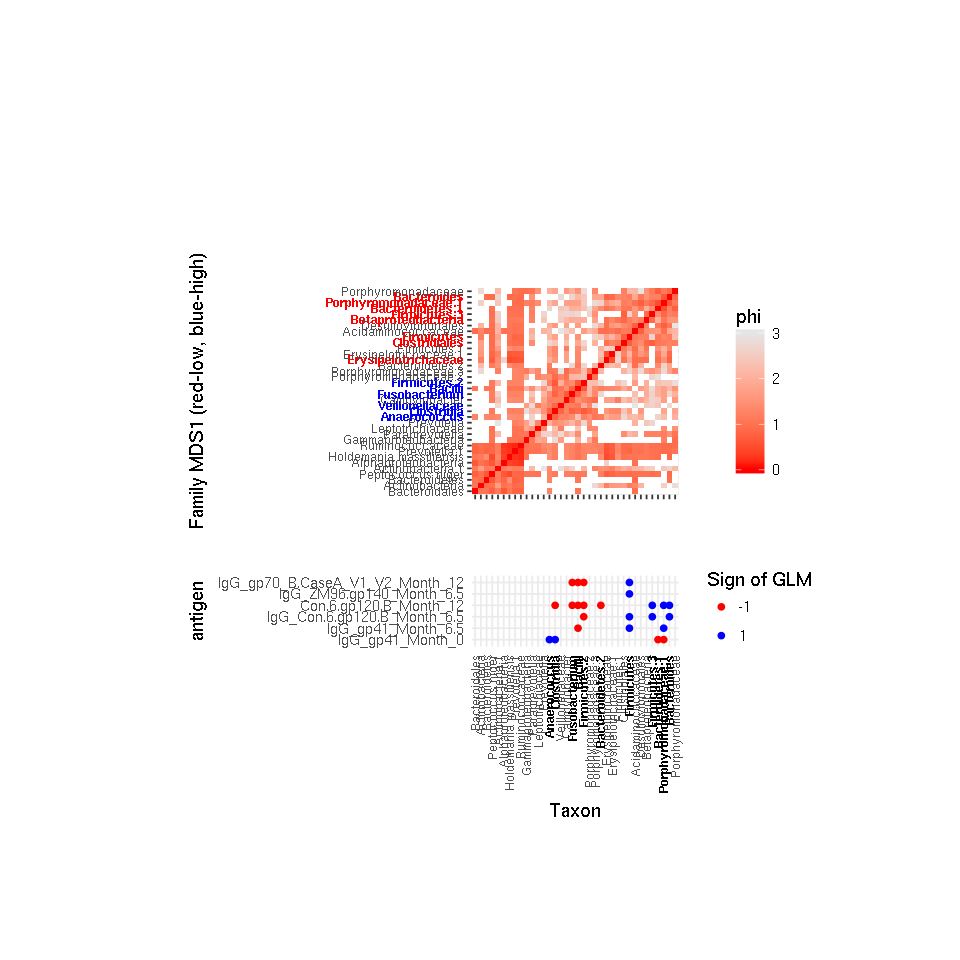

In [161]:
p_phi_1a <- p_phi_1 + 
theme(axis.text.x = element_blank(),
     axis.title.x = element_blank(),
     plot.margin = unit(c(1, 3, -5.5, 4), "cm"))

par <- options()
options(repr.plot.width=8, repr.plot.height= 8)

p_phi_cord <- cowplot::plot_grid(p_phi_1a, guitar_chords, nrow = 2, align = "v")

p_phi_cord

#phi_legend <- cowplot::get_legend(p_phi_1)
# cowplot::ggdraw(
#     cowplot::plot_grid(
#     cowplot::plot_grid(p_phi_1a, guitar_chords, ncol = 1, align = "v"),
#       cowplot::plot_grid(phi_legend, NULL, ncol = 1),
#       rel_widths = c(10,1)
#         ))

 ggsave('figures/phi_heatmap_withlegend.png', width = 10, height = 10)

options(par)

# Stacked bars

In [162]:
# More color-blind friendly colorbalettes
#http://colorbrewer2.org/#type=qualitative&scheme=Paired&n=10
cb10 <- c('#a6cee3','#1f78b4','#b2df8a','#33a02c','#fb9a99','#e31a1c','#fdbf6f','#ff7f00','#cab2d6','#6a3d9a')

cb12 <- c('#a6cee3','#1f78b4','#b2df8a','#33a02c','#fb9a99','#e31a1c','#fdbf6f','#ff7f00','#cab2d6','#6a3d9a','#ffff99','#b15928')

# Less color-blind friendly, but still nice.
#https://sashat.me/2017/01/11/list-of-20-simple-distinct-colors/
trub20 <- c('#e6194b','#3cb44b','#ffe119','#0082c8','#f58231','#911eb4','#46f0f0','#f032e6','#d2f53c','#fabebe','#008080','#e6beff','#aa6e28','#fffac8','#800000','#aaffc3','#808000','#ffd8b1','#000080','#808080','#FFFFFF','#000000')

In [163]:
options(repr.plot.width=8, repr.plot.height= 4)

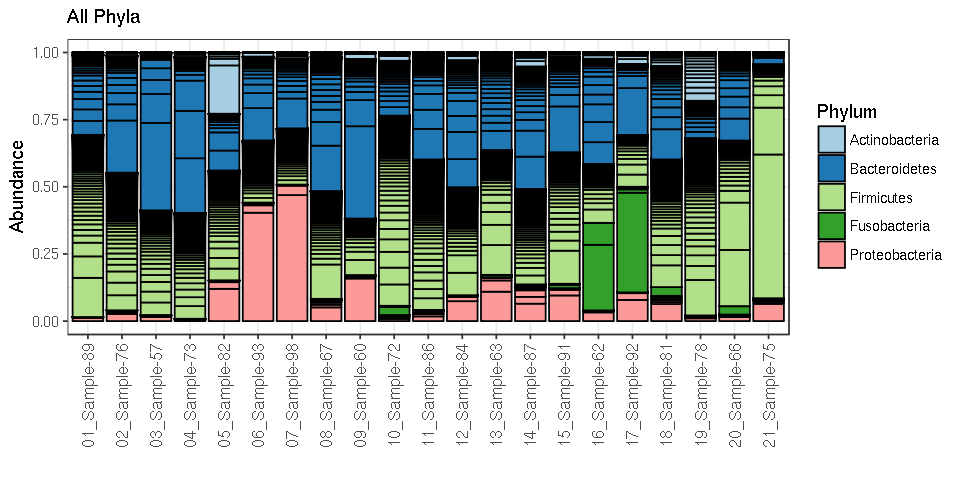

In [164]:
p_phy <- plot_bar(psN2, x = 'newname', fill = 'Phylum') + scale_fill_manual(values = cb10)  + xlab("") +
ggtitle("All Phyla")+ theme_bw() +
theme(axis.text.x = element_text(angle = 90, hjust = 1,, vjust = 0.5, size = 10),
     strip.text.y = (element_text(angle = 90)))
p_phy
#ggsave('plots/Phyla_by_wuf1.png')

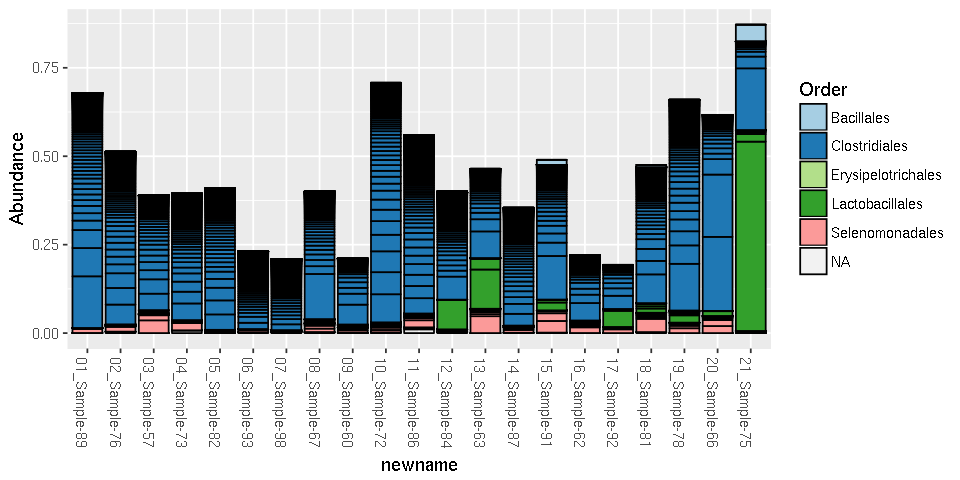

In [165]:
p_firm <-  subset_taxa(psN2, Phylum == 'Firmicutes') %>%
plot_bar( x = 'newname', fill = 'Order') + scale_fill_manual(values = cb10) #+ theme_bw()
p_firm
#ggsave('plots/MostFirmicutesAreClostridiales.png')

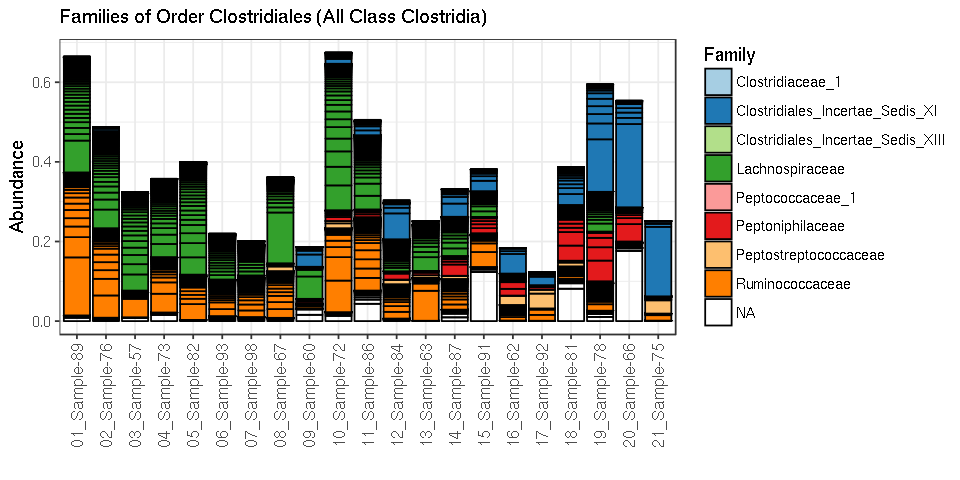

In [166]:
p_clostridia <-  subset_taxa(psN2, Class == 'Clostridia') %>%
plot_bar( x = 'newname', fill = 'Family') + scale_fill_manual(values = cb10)  + xlab("") +
ggtitle("Families of Order Clostridiales (All Class Clostridia)")+ theme_bw() +
theme(axis.text.x = element_text(angle = 90, hjust = 1,, vjust = 0.5, size = 10),
     strip.text.y = (element_text(angle = 90)))
p_clostridia

In [167]:
# p_porph <-  subset_taxa(psN2, Family == 'Porphyromonadaceae') %>%
# plot_bar( x = 'newname', fill = 'Genus') + scale_fill_manual(values = cb10) #+ theme_bw()
# p_porph

In [168]:
# p_bact <- subset_taxa(psN2, Phylum == 'Bacteroidetes') %>% # all class (Bacteroidia), order (Bacteroidales)
# plot_bar(x = 'newname', fill = 'Family') + scale_fill_manual(values = cb10) #+ theme_bw()
# p

# ggsave('figures/Bacteroidetes_Families.png')

Saving 6.67 x 6.67 in image


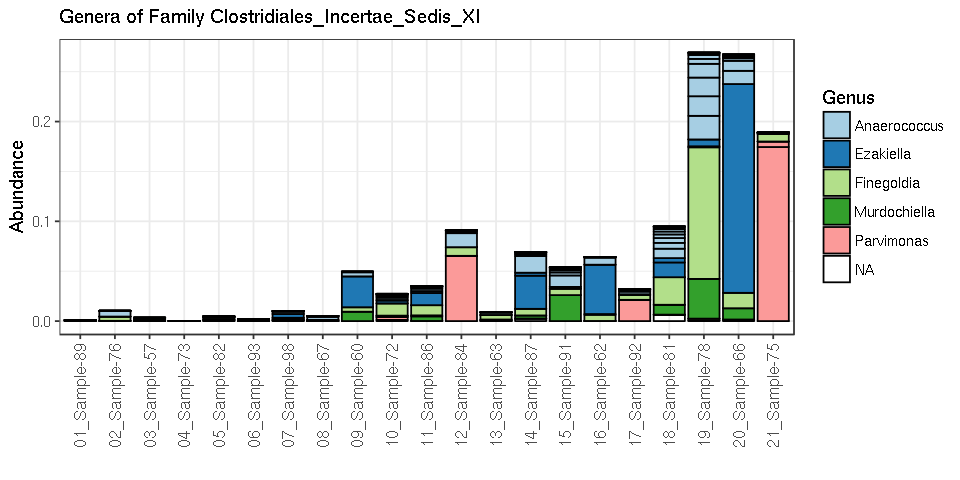

In [169]:
p_ClosXI <- subset_taxa(psN2, Family == 'Clostridiales_Incertae_Sedis_XI') %>%
plot_bar( x = 'newname', fill = 'Genus') + scale_fill_manual(values = cb10) + xlab("") +
ggtitle("Genera of Family Clostridiales_Incertae_Sedis_XI")+ theme_bw() +
theme(axis.text.x = element_text(angle = 90, hjust = 1,, vjust = 0.5, size = 10),
     strip.text.y = (element_text(angle = 90)))
p_ClosXI
ggsave('figures/Clostridiales_Incertae_Sedis_XI_Genus.png')

Saving 6.67 x 6.67 in image


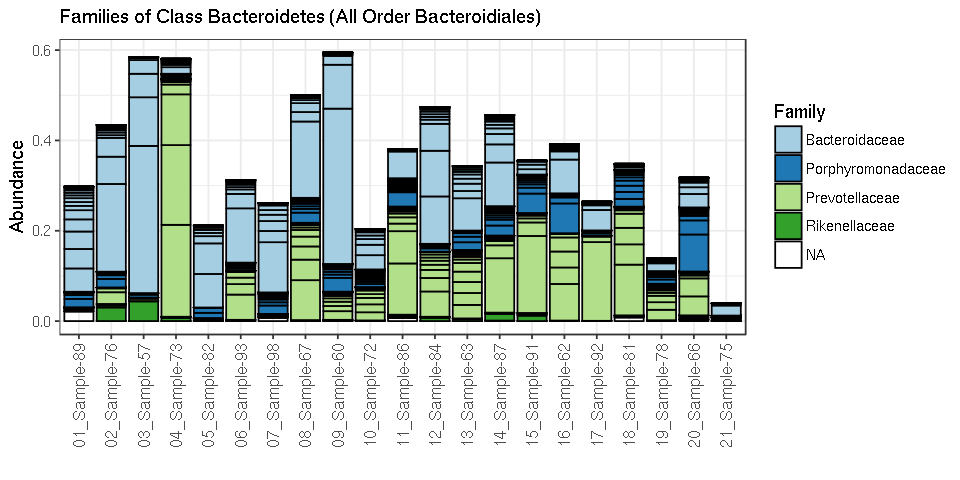

In [170]:

p_Bact <- subset_taxa(psN2, Phylum == 'Bacteroidetes') %>%
plot_bar( x = 'newname', fill = 'Family') + scale_fill_manual(values = cb10) + xlab("") +
ggtitle("Families of Class Bacteroidetes (All Order Bacteroidiales)")+ theme_bw() +
theme(axis.text.x = element_text(angle = 90, hjust = 1,, vjust = 0.5, size = 10),
     strip.text.y = (element_text(angle = 90)))
p_Bact
ggsave('figures/Bacteroides.png')

In [171]:
lay <- rbind(c(1,2), c(3,4))

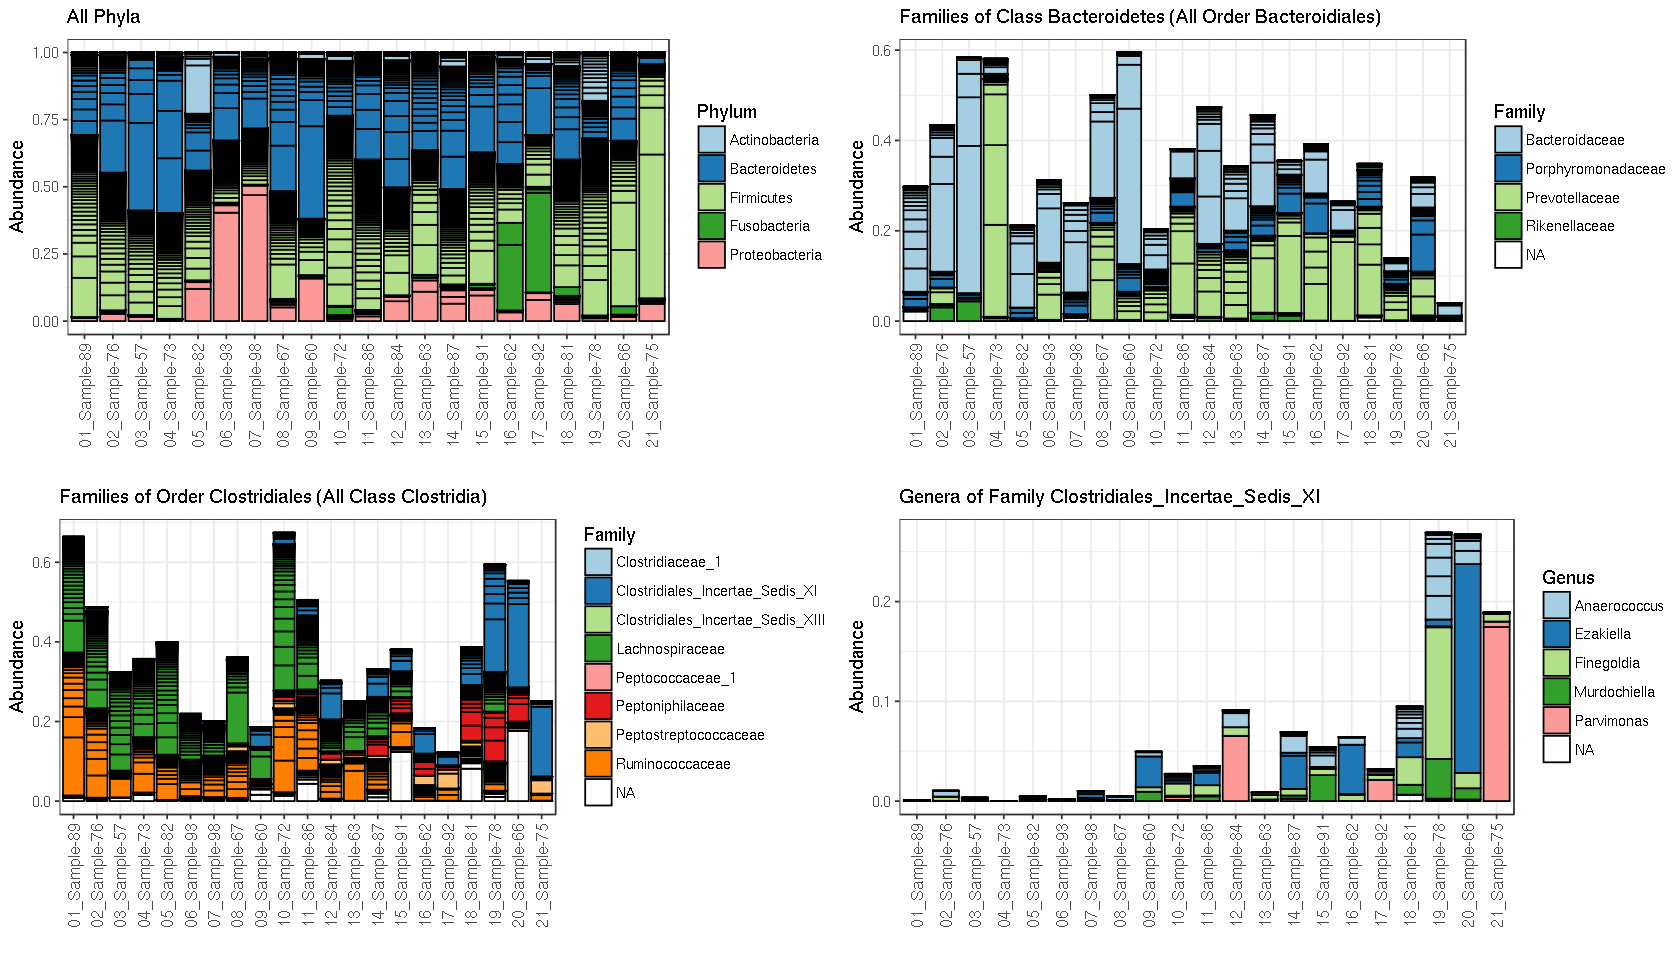

In [172]:
options(repr.plot.width=14, repr.plot.height= 8)
grid.arrange(p_phy, p_Bact,p_clostridia,p_ClosXI, layout_matrix = lay)

In [173]:
stacked_bars <- arrangeGrob(
    p_phy, p_Bact,p_clostridia,p_ClosXI, layout_matrix = lay
)
ggsave('figures/stacked_bars.png', stacked_bars, width = 14, height = 8)

# Exporting OTU tables and Taxa tables at each agglomeration level

In [174]:
psDf %>%
mutate(OTU = map(ps, ~data.frame(otu_table(.)))) %>%
mutate(Tax = map(ps, ~data.frame(tax_table(.)))) %>%
mutate(OTUCount = map (psCount, ~data.frame(otu_table(.)))) %>%
pass -> psDf1


In [175]:
print(psDf1)

# A tibble: 6 x 12
  taxLevels ntaxa psCount  ps     jsd   jsdMat kjsd  psNoZero clr   OTU   Tax  
  <chr>     <int> <list>   <list> <lis> <list> <lis> <list>   <lis> <lis> <lis>
1 Phylum        5 <S4: ph… <S4: … <S3:… <dbl … <dbl… <S4: ph… <S4:… <dat… <dat…
2 Class        12 <S4: ph… <S4: … <S3:… <dbl … <dbl… <S4: ph… <S4:… <dat… <dat…
3 Order        17 <S4: ph… <S4: … <S3:… <dbl … <dbl… <S4: ph… <S4:… <dat… <dat…
4 Family       36 <S4: ph… <S4: … <S3:… <dbl … <dbl… <S4: ph… <S4:… <dat… <dat…
5 Genus        90 <S4: ph… <S4: … <S3:… <dbl … <dbl… <S4: ph… <S4:… <dat… <dat…
6 Species     536 <S4: ph… <S4: … <S3:… <dbl … <dbl… <S4: ph… <S4:… <dat… <dat…
# ... with 1 more variable: OTUCount <list>


In [176]:
# Show which species level OTUs are contained in each agglomerated group:
psDf1 %>%
.[1:5,] %>%
mutate(TaxIdx = map(Tax, function(df){
    df %>%
    mutate(tag = as.character(tag), oldGroups = as.character(oldGroups)) %>%
    dplyr::select(tag, oldGroups) %>%
    mutate(oldGroups = strsplit(oldGroups, ",")) %>%
    unnest(oldGroups)
})) %>%
dplyr::select(taxLevels, TaxIdx) %>%
unnest(TaxIdx) %>%
mutate(oldGroups = trimws(oldGroups)) %>% # Some of these have leading or trailing whitespace
spread(taxLevels, tag) %>%
dplyr::select(oldGroups, Phylum, Class, Order, Family, Genus) %>%
pass -> taxGroupMapping
write_csv(taxGroupMapping, 'tables/taxGroupMapping.csv')

In [177]:
# Print out each otu table (relative abundances).
walk2(psDf1$taxLevels, psDf1$OTU, 
      ~write.csv(.y, file = paste0("tables/OTU/otu_",.x, ".csv")))

In [178]:
# Print out each otu table (counts).
walk2(psDf1$taxLevels, psDf1$OTUCount, 
      ~write.csv(.y, file = paste0("tables/OTU/otuCount_",.x, ".csv")))

In [179]:
# Print out each taxonomy table.
walk2(psDf1$taxLevels, psDf1$Tax, 
      ~write.csv(.y, file = paste0("tables/Tax/tax_",.x, ".csv")))